# Problem 1

## (a)


We use EM algorithm to estimate $\pi$ and $\sigma^2$, and calculate $\hat \mu_i^S$ by the algorithm's output.

From the hierarchical model，we can derive
$$
z_i \mid {\gamma_i = 0} \sim \mathcal{N}(0, 1), \\
z_i \mid {\gamma_i = 1 }\sim \mathcal{N}(0, 1 + \sigma^2),
$$

For each i
$$
p(z_i,\gamma_i|\pi,\sigma^2) = p(\gamma_i|\pi)p(z_i|\gamma_i,\sigma^2)
$$

By the defination

$$
p(\gamma_i|\pi) = \pi^{\gamma_i}(1-\pi)^{1-\gamma_i}
\\
p(z_i|\gamma_i,\sigma^2)=[\phi(z_i;0,1+\sigma^2)]^{\gamma_i}[\phi(z_i;0,1)]^{(1-\gamma_i)}
$$

where 
$
\phi(z;a,b) = (2\pi b)^{-1/2} \exp\!\left(-\frac{(z-a)^2}{2b}\right).
$ is the probabilty density funtion of normal distribution

Thus we can deduce
$$
p(z_i,\gamma_i|\pi,\sigma^2)=[\pi\phi(z_i;0,1+\sigma^2)]^{\gamma_i}[\pi\phi(z_i;0,1)]^{(1-\gamma_i)}
$$

And then the complete-data log-likelihood is

$$
\ell_c(\pi,\sigma^2)
=\sum_{i=1}^N
\Big[
\gamma_i\big(\log\pi+\log\phi(z_i;0,1+\sigma^2)\big)
+(1-\gamma_i)\big(\log(1-\pi)+\log\phi(z_i;0,1)\big)
\Big],
$$



which equal to 

$$
\ell_c(\pi,\sigma^2)
=\sum_{i=1}^N
\Big[
\gamma_i\Big(\log\pi - \frac{1}{2}\log(1+\sigma^2) - \frac{z_i^2}{2(1+\sigma^2)}\Big)
+(1-\gamma_i)\log(1-\pi)
\Big] + C
$$





$C$ includes all terms that are unrelated to $\pi$ and $\sigma^2$

### E step

Define the responsibility
$$
w_i^{(t)} = \mathbb E[\gamma_i \mid z_i;\pi^{(t)},\sigma^{2(t)}]
= P(\gamma_i=1\mid z_i;\pi^{(t)},\sigma^{2(t)}).
= \frac{\pi^{(t)}p(z_i|\gamma_i=1,\sigma^{2(t)})}{\pi^{(t)}p(z_i|\gamma_i=1,\sigma^{2(t)})+(1-\pi^{(t)})p(z_i|\gamma_i=0)}.
$$


Thus 
$$
Q(\pi,\sigma^2|\pi^{(t)},\sigma^{2(t)}) = \sum_{i=1}^N [w_i^{(t)}(\log\pi - \frac{1}{2}\log(1+\sigma^2) - \frac{z_i^2}{2(1+\sigma^2)} )+(1-w_i^{(t)})\log(1-\pi)] +C
$$

### M step


$$
\frac{\partial Q}{\partial \pi}
=\sum_{i=1}^N\Big(\frac{w_i^{(t)}}{\pi}-\frac{1-w_i^{(t)}}{1-\pi}\Big)=0
\quad\Rightarrow\quad
\pi^{(t+1)}=\frac{1}{N}\sum_{i=1}^N w_i^{(t)}.
$$




$$
\frac{\partial Q}{\partial \sigma^2}
=\sum_{i=1}^N w_i^{(t)}\Big(-\frac{1}{2(1+\sigma^2)}+\frac{z_i^2}{2(1+\sigma^2)^2}\Big)=0.
\quad\Rightarrow\quad
\sigma^{2(t+1)}=\frac{\sum_{i=1}^N w_i^{(t)} z_i^2}{\sum_{i=1}^N w_i^{(t)}}-1. (\ge 0)

$$



Repeat E step and M step until the parameters converge, yielding $\hat \pi$ and $\hat \sigma^2$, using these estimates, compute the posterior mean

$$
\hat{w}_{i}=\frac{\hat{\pi}\mathrm{~}\phi{\left(z_{i};0,\mathrm{~}1+\hat{\sigma}^{2}\right)}}{\hat{\pi}\mathrm{~}\phi{\left(z_{i};0,\mathrm{~}1+\hat{\sigma}^{2}\right)}+(1-\hat{\pi})\phi{\left(z_{i};0,\mathrm{~}1\right)}}
\\
\hat{\mu}_{i}^{S}=\hat{w}_{i}\frac{\hat{\sigma}^{2}}{1+\hat{\sigma}^{2}}z_{i}.
$$

## (b)

### Function

For Tweedie’s formula, we estimate the marginal density $f(z)$ using KDE with the Gaussian kernel $\phi(u)=\frac{1}{\sqrt{2\pi}}e^{-u^{2}/2}$:


$$
\hat{f}(z)=\frac{1}{Nh}\sum_{j=1}^N\phi{\left(\frac{z-z_j}{h}\right)}.
$$

The bandwidth $h$ is selected using Silverman’s rule:
$h = 1.06\,\hat{s}\,N^{-1/5}$, where $\hat{s}$ is the sample standard deviation.

Thus the score function is 

$$
\frac{d}{dz}\log\hat{f}(z)=-\frac{\sum_{j=1}^N\frac{z-z_j}{h^2}\phi{\left(\frac{z-z_j}{h}\right)}}{\sum_{j=1}^N\phi{\left(\frac{z-z_j}{h}\right)}}
$$

thus the Tweedie estimator is

$$
\hat{\mu}_i^{\mathrm{Tw}}=z_i+\frac{d}{dz}\log\hat{f}(z_i) = z_i -\frac{\sum_{j=1}^N\frac{z_i-z_j}{h^2}\phi{\left(\frac{z_i-z_j}{h}\right)}}{\sum_{j=1}^N\phi{\left(\frac{z_i-z_j}{h}\right)}}
$$


In [84]:
##
# Tweedie's formular 
# KDE to estimate the density function
##
import numpy as np
def tweedie(z, tau2=1.0, eps=1e-12, h=None):
    z = np.asarray(z, dtype=float).ravel()
    N = z.size

    if N == 0:
        return np.array([]), np.nan
    if N == 1:
        return z.copy(), 1.0

    # --- Silverman's rule of thumb (classic) ---
    if h is None:
        s = np.std(z, ddof=1)  # unbiased std
        if s == 0:
            s = 1.0  # fallback if all z are identical
        h = 1.06 * s * (N ** (-1.0 / 5.0)) 

    # Precompute constants
    inv_h = 1.0 / h
    inv_h2 = inv_h * inv_h

    # Pairwise differences: shape (N, N)
    diff = z[:, None] - z[None, :]          # z_i - z_j
    u = diff * inv_h                        # (z_i - z_j) / h

    # Gaussian kernel (constant factor cancels, so omit 1/sqrt(2π))
    K = np.exp(-0.5 * u * u)                # proportional to φ(u)

    # Denominator: sum_j K_ij
    den = np.sum(K, axis=1)

    # Numerator: sum_j (z_i - z_j)/h^2 * K_ij
    num = -1* (diff * K).sum(axis=1) * inv_h2


    # Score = d/dz log f_hat(z_i)
    score = num / np.maximum(den, eps)

    # Tweedie estimate
    mu_hat = z + tau2 * score

    return mu_hat


JSE:  
$$
\hat{\boldsymbol{\mu}}^{\mathrm{~JS}}=\left(1-\frac{d-2}{\|\mathbf{z}\|^{2}}\right)_{+}\mathbf{z},
$$

In [71]:

def JSE(z, sigma2=1.0, center=None, positive_part=True):

    z = np.asarray(z, dtype=float)
    original_shape = z.shape

    if z.ndim == 1:
        z = z[None, :]  # shape (1, d)
        squeeze_output = True
    else:
        squeeze_output = False

    N, d = z.shape

    if d < 3:
        raise ValueError("James-Stein estimator is only defined for dimension d >= 3")
        pass

    # Set center
    if center is None:
        center = np.zeros(d)
    else:
        center = np.asarray(center, dtype=float)
        if center.shape != (d,):
            raise ValueError(f"center must be shape ({d},), got {center.shape}")

    # Center the data
    z_centered = z - center  # shape (N, d)

    # Squared norm: ||z - center||^2, shape (N,)
    norm_sq = np.sum(z_centered**2, axis=1)

    # Avoid division by zero
    eps = np.finfo(float).eps
    norm_sq = np.maximum(norm_sq, eps)

    # Shrinkage factor: (d - 2) * sigma2 / ||z - center||^2
    shrinkage = (d - 2) * sigma2 / norm_sq  # shape (N,)

    if positive_part:
        factor = np.maximum(1.0 - shrinkage, 0.0)
    else:
        factor = 1.0 - shrinkage

    # Apply shrinkage
    mu_hat = center + (factor[:, None] * z_centered)

    # Reshape to match input
    if squeeze_output:
        mu_hat = mu_hat[0]

    return mu_hat

EM：Provided in （a）

In [72]:

def em_spike_slab(z, pi_init=0.2, sigma2_init=1.0, tol=1e-6, max_iter=1000,
                  min_sigma2=1e-8, return_history=False):

    z = np.asarray(z, dtype=float).ravel()
    N = z.size

    # --- helpers ---
    def log_norm_pdf(x, mean, var):
        return -0.5 * (np.log(2.0 * np.pi * var) + (x - mean) ** 2 / var)

    def obs_loglik(pi, sigma2):
        # log [ pi * N(0,1+sigma2) + (1-pi) * N(0,1) ] summed over i
        la = np.log(pi)   + log_norm_pdf(z, 0.0, 1.0 + sigma2)
        lb = np.log(1-pi) + log_norm_pdf(z, 0.0, 1.0)
        m = np.maximum(la, lb)
        return np.sum(m + np.log(np.exp(la - m) + np.exp(lb - m)))

    # --- init ---
    pi = float(np.clip(pi_init, 1e-6, 1-1e-6))
    sigma2 = float(max(sigma2_init, min_sigma2))
    last_ll = -np.inf

    if return_history:
        hist_pi, hist_s2, hist_ll = [], [], []

    for t in range(1, max_iter + 1):
        # E-step: responsibilities w_i = P(gamma=1 | z_i, pi, sigma2)
        la = np.log(pi)   + log_norm_pdf(z, 0.0, 1.0 + sigma2)
        lb = np.log(1-pi) + log_norm_pdf(z, 0.0, 1.0)
        m  = np.maximum(la, lb)
        a  = np.exp(la - m)
        b  = np.exp(lb - m)
        w  = a / (a + b)                 # shape (N,)

        # M-step:
        pi_new = np.clip(np.mean(w), 1e-12, 1 - 1e-12)
        denom = np.sum(w)
        if denom < 1e-16:
            sigma2_new = min_sigma2      # degenerate case: all weights ~ 0
        else:
            sigma2_new = np.sum(w * z**2) / denom - 1.0
            sigma2_new = float(max(sigma2_new, min_sigma2))

        # Check convergence via observed-data log-likelihood
        ll = obs_loglik(pi_new, sigma2_new)

        if return_history:
            hist_pi.append(pi_new)
            hist_s2.append(sigma2_new)
            hist_ll.append(ll)

        if np.isfinite(last_ll) and abs(ll - last_ll) <= tol * (1.0 + abs(last_ll)):
            pi, sigma2 = pi_new, sigma2_new
            break

        pi, sigma2 = pi_new, sigma2_new
        last_ll = ll

    # Posterior mean with the learned params
    la = np.log(pi)   + log_norm_pdf(z, 0.0, 1.0 + sigma2)
    lb = np.log(1-pi) + log_norm_pdf(z, 0.0, 1.0)
    m  = np.maximum(la, lb)
    a  = np.exp(la - m)
    b  = np.exp(lb - m)
    w  = a / (a + b)

    shrink = sigma2 / (1.0 + sigma2)
    mu_hat = w * shrink * z

    if return_history:
        return pi, sigma2, mu_hat, {
            "pi": np.array(hist_pi),
            "sigma2": np.array(hist_s2),
            "loglik": np.array(hist_ll),
            "iters": t,
        }
    return pi, sigma2, mu_hat



### Simulation

In [ ]:
def generate_data(
    N: int,
    pi: float,
    sigma2: float = 1.0,
    tau2: float = 1.0,
    rng: np.random.Generator | None = None,
):

    if rng is None:
        rng = np.random.default_rng()
    if not (0.0 < pi < 1.0):
        raise ValueError("pi must be in (0,1).")
    if sigma2 < 0 or tau2 < 0:
        raise ValueError("sigma2 and tau2 must be nonnegative.")

    gamma = rng.binomial(1, pi, size=N).astype(int)
    mu = rng.normal(0.0, np.sqrt(sigma2), size=N) * gamma
    z = mu + rng.normal(0.0, np.sqrt(tau2), size=N)
    return mu, z, gamma



We compare three estimators—the EM-based Spike–Slab, the James–Stein, and the Tweedie (KDE) estimators for the sparse normal means model $z_i=\mu_i+\varepsilon_i$, $\varepsilon_i\sim\mathcal N(0,1)$.

Data are generated from a spike–slab prior with sparsity $\pi\in\{0.01,0.05,0.10,0.20,0.50,0.80\}$ and sample sizes $N\in\{10,50,200,1000\}$, fixing $\sigma^2=1$.

Each method is evaluated by mean squared error (MSE) over 200 Monte Carlo replications.


In [98]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def mse(a, b):
    """Compute mean squared error between two arrays."""
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

pi_grid = (0.05, 0.10, 0.20, 0.4,0.50, 0.6,0.8,0.9,0.95)
N_grid = (10, 50, 200, 1000,3000)
R = 200  # number of Monte Carlo replicates
sigma2_true = 1.0  # slab variance
tau2_true = 1.0    # observation noise variance
rng_seed = 0

rng = np.random.default_rng(rng_seed)
results = {}

# Run simulation
for N in N_grid:
    for pi in pi_grid:
        mses_S = []
        mses_JS = []
        mses_Tw = []

        for _ in range(R):
            # 1) Generate data
            mu_true, z, _ = generate_data(
                N=N, pi=pi, sigma2=sigma2_true, tau2=tau2_true, rng=rng
            )

            # 2a) Spike–Slab posterior mean via EM (plugin EB)
            pi_init, s2_init = 0.2, 1.0
            _, _, mu_hat_S = em_spike_slab(z, pi_init=pi_init, sigma2_init=s2_init)

            # 2b) James–Stein (positive-part)
            mu_hat_JS = JSE(z, sigma2=tau2_true, center=None, positive_part=True)

            # 2c) Tweedie (KDE)
            mu_hat_Tw = tweedie(z, tau2=tau2_true)

            # 3) Record MSEs
            mses_S.append(mse(mu_hat_S, mu_true))
            mses_JS.append(mse(mu_hat_JS, mu_true))
            mses_Tw.append(mse(mu_hat_Tw, mu_true))

        # Compute mean and standard error
        def mean_se(x):
            x = np.asarray(x, dtype=float)
            return float(x.mean()), float(x.std(ddof=1) / np.sqrt(len(x)))

        results[(N, pi)] = {
            "S": mean_se(mses_S),
            "JS": mean_se(mses_JS),
            "Tw": mean_se(mses_Tw),
        }

# ------------------------------------------------------------
# Print example summary
# ------------------------------------------------------------
N_show, pi_show = 200, 0.10
row = results[(N_show, pi_show)]



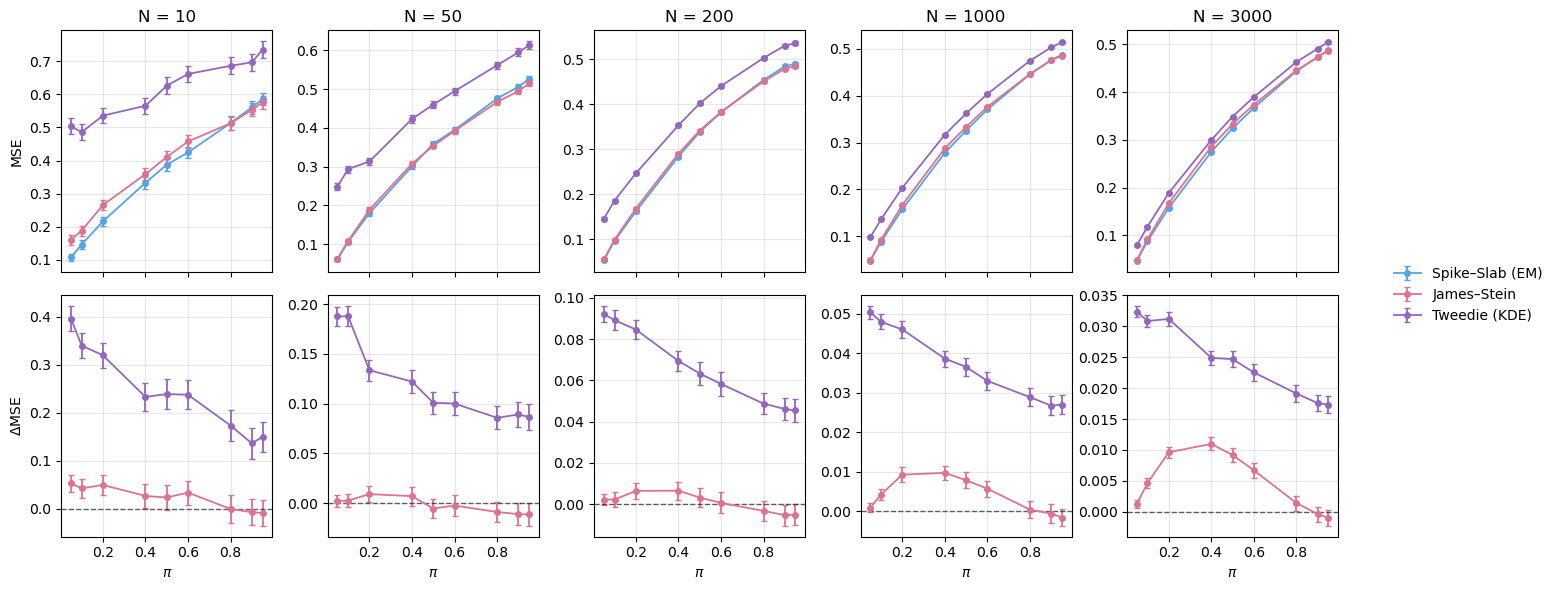

In [103]:
# ------------------------------------------------------------
# Plotting: Combined MSE and ΔMSE relative to EM
# Top row: MSE of S, JS, Tw
# Bottom row: ΔMSE = MSE(method) - MSE(S) for JS and Tw
# ------------------------------------------------------------
methods_mse = ["S", "JS", "Tw"]
labels = {
    "S": "Spike–Slab (EM)",
    "JS": "James–Stein",
    "Tw": "Tweedie (KDE)"
}
colors = {
    "S": "#55A3E7",   # light blue
    "JS": "#DC7391",  # rose pink
    "Tw": "#9467BD"   # purple
}

fig, axes = plt.subplots(2, len(N_grid), figsize=(14, 6), sharex=True)
if len(N_grid) == 1:
    axes = np.array([[axes[0]], [axes[1]]])

for col, N in enumerate(N_grid):
    ax_top = axes[0, col]
    ax_bot = axes[1, col]

    # --- Top: MSE curves ---
    for m in methods_mse:
        y  = [results[(N, pi)][m][0] for pi in pi_grid]
        se = [results[(N, pi)][m][1] for pi in pi_grid]
        ax_top.errorbar(
            pi_grid, y, yerr=se,
            marker='o', markersize=4, linewidth=1.3,
            linestyle='-', color=colors[m], label=labels[m], capsize=2
        )
    ax_top.set_title(f"N = {N}")
    ax_top.grid(True, alpha=0.3)
    if col == 0:
        ax_top.set_ylabel("MSE")

    # --- Bottom: ΔMSE curves ---
    y_S  = np.array([results[(N, pi)]["S"][0] for pi in pi_grid])
    se_S = np.array([results[(N, pi)]["S"][1] for pi in pi_grid])

    for m in ["JS", "Tw"]:
        y_m  = np.array([results[(N, pi)][m][0] for pi in pi_grid])
        se_m = np.array([results[(N, pi)][m][1] for pi in pi_grid])
        delta = y_m - y_S
        delta_se = np.sqrt(se_m**2 + se_S**2)
        ax_bot.errorbar(
            pi_grid, delta, yerr=delta_se,
            marker='o', markersize=4, linewidth=1.3,  # 改这里
            linestyle='-', color=colors[m], label=labels[m], capsize=2
        )
    ax_bot.axhline(0, color='k', lw=1, ls='--', alpha=0.6)
    ax_bot.grid(True, alpha=0.3)
    ax_bot.set_xlabel(r"$\pi$")
    if col == 0:
        ax_bot.set_ylabel(r"$\Delta$MSE")

# Legend on right side
handles, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, [labels[m] for m in methods_mse],
           loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  # Leave space for legend
plt.show()


The figure presents a comparison of the Spike–Slab (EM), James–Stein, and Tweedie (KDE) estimators across different sparsity levels $((\pi))$ and sample sizes $(N)$. The top panels display the mean squared error (MSE) of each estimator, while the bottom panels show the MSE differences between each method and the Spike–Slab (EM) baseline $(\Delta\text{MSE} = \text{MSE}*{\text{method}} - \text{MSE}*{\text{EM}})$.

From the top row, we observe that MSE increases with $\pi$ and decreases with larger $N$, consistent with the expectation that denser signals are harder to estimate while larger samples stabilize estimation. The EM-based Spike–Slab generally achieves the lowest MSE, with James–Stein closely following and Tweedie performing significantly worse, especially for small $N$ or highly sparse signals.


The bottom row highlights these differences more clearly. For small sample sizes, both James–Stein and Tweedie exhibit higher MSEs than EM, but as $N$ increases, their performance gaps shrink. Notably, the James–Stein estimator slightly outperforms EM for moderate $\pi$ values. Tweedie’s performance consistently improves with larger $N$, though it remains less stable due to its reliance on kernel density estimation.

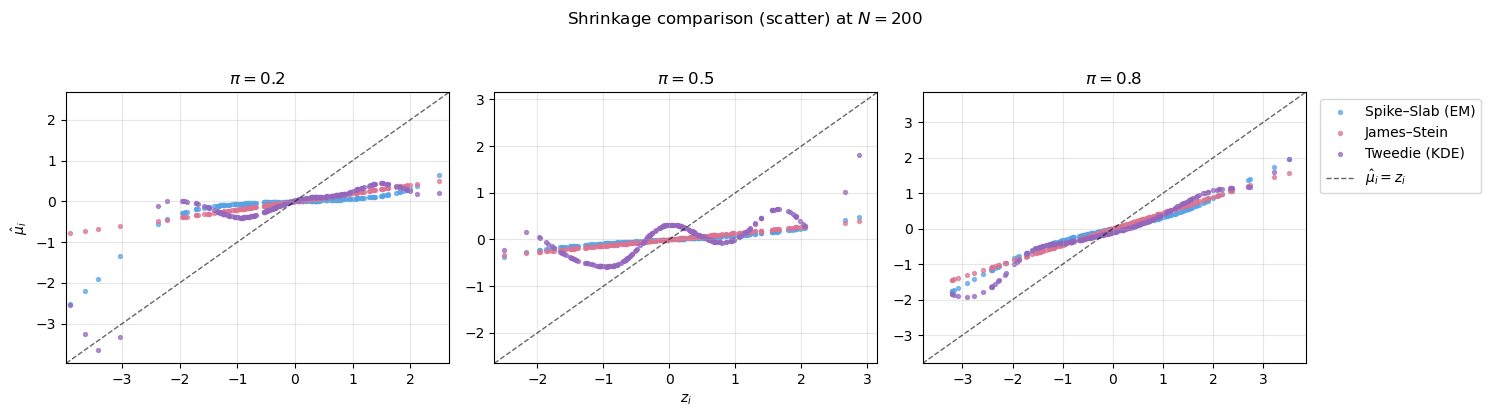

In [120]:
# ------------------------------------------------------------
# Scatter plot: shrinkage effect for multiple π values at N=200
# One row only (EM, JS, Tweedie)
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

N_show = 200
pi_list = [0.2, 0.5, 0.8]
sigma2_true, tau2_true = 1.0, 1.0
rng = np.random.default_rng(0)

colors = {
    "S": "#55A3E7",   # light blue
    "JS": "#DC7391",  # rose pink
    "Tw": "#9467BD"   # purple
}

fig, axes = plt.subplots(1, len(pi_list), figsize=(15, 4), sharex=False, sharey=False)

for ax, pi in zip(axes, pi_list):
    mu_true, z, _ = generate_data(
        N=N_show, pi=pi, sigma2=sigma2_true, tau2=tau2_true, rng=rng
    )

    # 三种估计器
    _, _, mu_S = em_spike_slab(z, pi_init=0.2, sigma2_init=1.0)
    mu_JS = JSE(z, sigma2=tau2_true, center=None, positive_part=True)
    mu_Tw = tweedie(z, tau2=tau2_true)

    # 散点图（小点，透明度略高）
    ax.scatter(z, mu_S, s=8, alpha=0.7, color=colors["S"], label="Spike–Slab (EM)")
    ax.scatter(z, mu_JS, s=8, alpha=0.7, color=colors["JS"], label="James–Stein")
    ax.scatter(z, mu_Tw, s=8, alpha=0.7, color=colors["Tw"], label="Tweedie (KDE)")

    # 无收缩参考线
    zmin, zmax = np.percentile(z, [1, 99])
    pad = 0.1 * (zmax - zmin)
    lo, hi = zmin - pad, zmax + pad
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1, alpha=0.6, label=r'$\hat{\mu}_i = z_i$')

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_title(rf"$\pi={pi}$")
    ax.grid(alpha=0.3)

# 坐标轴标签
axes[0].set_ylabel(r"$\hat{\mu}_i$")
axes[len(pi_list)//2].set_xlabel(r"$z_i$")

# 图例放右侧
axes[-1].legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.suptitle(r"Shrinkage comparison (scatter) at $N=200$", y=1.03)
plt.tight_layout()
plt.show()




The figure compares the shrinkage behavior of three estimators Spike–Slab (EM), James–Stein, and Tweedie (KDE) for varying sparsity levels $ \pi = 0.2, 0.5, 0.8 $. Each plot shows how the estimated means $\hat{\mu}_i$ relate to the observed data $z_i$, with the dashed line representing the no-shrinkage baseline $\hat{\mu}_i = z_i$.

At low sparsity $\pi = 0.2 $, the Spike–Slab estimator shows strong shrinkage toward zero for most observations, closely resembling James–Stein, while Tweedie displays slightly unstable oscillations due to density estimation noise.
As $\pi$ increases to (0.5), the estimates spread more, reflecting weaker shrinkage. The Tweedie estimator exhibits visible fluctuations around the diagonal, while EM and James–Stein remain smooth and nearly overlapping.
At high density $\pi = 0.8 $, all methods align closely with the diagonal, indicating minimal shrinkage when the signal is dense.




## (c)

### q1

We employ an Expectation–Maximization (EM) algorithm, where the parameter set becomes $\theta = (\beta_0,\beta,\sigma^2)$

$$
\log\frac{\Pr(\gamma_i=1\mid a_i)}{\Pr(\gamma_i=0\mid a_i)}=\beta_0+\beta a_i\quad\Rightarrow\quad\pi_i:=\Pr(\gamma_i=1\mid a_i)=\sigma(\beta_0+\beta a_i)
$$

with similar steps in (a), we can deduce

#### E step

$$
w_i^{(t+1)}:=\Pr(\gamma_i=1\mid z_i,a_i;\theta^{(t)})=\frac{\pi_i^{(t)}\mathrm{~}\phi{\left(z_i;0,1+\sigma^{2(t)}\right)}}{\pi_i^{(t)}\mathrm{~}\phi{\left(z_i;0,1+\sigma^{2(t)}\right)}+\left(1-\pi_i^{(t)}\right)\mathrm{~}\phi{\left(z_i;0,1\right)}}.
$$



$$
\begin{aligned}
Q\!\left(\theta \mid \theta^{(t)}\right)&=\mathbb{E}_{\gamma \mid z,a,\theta^{(t)}}\!\left[\log p\!\left(z,\gamma \mid a;\theta\right)\right]\\
&=\sum_{i=1}^N \Big[
w_i^{(t)}\log \pi_i + \big(1-w_i^{(t)}\big)\log\!\big(1-\pi_i\big)
\Big] +\sum_{i=1}^N \Big[
w_i^{(t)}\log \phi\!\big(z_i;0,1+\sigma^2\big)
+\big(1-w_i^{(t)}\big)\log \phi\!\big(z_i;0,1\big)
\Big],
\end{aligned}
$$

$$
\pi_i=\sigma(\beta_0+\beta a_i), \qquad
\phi(\,\cdot\,;0,v)\ \text{is the }\mathcal N(0,v)\text{ density.}
$$



#### M step


$$
(\beta_0^{(t+1)},\beta^{(t+1)}) 
\;=\;
\arg\max_{\beta_0,\beta}\;
\sum_{i=1}^N 
\Big[
w_i^{(t)}\log \sigma(\beta_0 + \beta a_i)
+\big(1-w_i^{(t)}\big)\log\!\big(1- \sigma(\beta_0 + \beta a_i) \big)
\Big].
$$


$$
\sigma^{2\,(t+1)}
=\max\!\left\{\,0,\;
\frac{\sum_{i=1}^N w_i^{(t)} z_i^2}{\sum_{i=1}^N w_i^{(t)}}-1
\right\}.
$$


Repeat E step and M step could yield estimates of $\beta_0$ and $\beta$

The next code implements the EM algorithm for a two-component latent variable model.  
In the E-step, it computes soft responsibilities $w_i = P(\gamma_i=1 \mid z_i, a_i)$ using a stable log-sum-exp form.  
In the M-step, $\sigma^2$ is updated by 
$\sigma^2 = \max(0, \frac{\sum_i w_i z_i^2}{\sum_i w_i} - 1)$.  

The optimization of $\beta = (\beta_0, \beta)$ is done by using IRLS.



In [162]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def em_fit_beta(z, a, 
                  beta0_init=0.0, beta_init=0.0, sigma2_init=1.0,
                  em_max_iter=200, em_tol=1e-8):

    def log_norm0_var(z, var):
        return -0.5*(np.log(2.0*np.pi*var) + (z*z)/var)

    def estep_w(z, a, beta0, beta, sigma2):
        eta = beta0 + beta * a
        pi = sigmoid(eta)                             # pi_i
        l1 = log_norm0_var(z, 1.0 + sigma2) + np.log(pi + 1e-12)     # log numerator
        l0 = log_norm0_var(z, 1.0)           + np.log(1.0 - pi + 1e-12)
        m = np.maximum(l1, l0)
        den = np.exp(l1 - m) + np.exp(l0 - m)
        w = np.exp(l1 - m) / (den + 1e-12)
        return w

    def mstep_sigma2(z, w):
        num = np.sum(w * (z**2))
        den = np.sum(w) + 1e-12
        val = num/den - 1.0
        return max(0.0, float(val))

    def mstep_logistic_IRLS(a, w_soft, beta0_init, beta_init, 
                            max_iter=50, tol=1e-8):
        x0 = np.ones_like(a)
        X = np.column_stack([x0, a])          # 截距+自变量
        theta = np.array([beta0_init, beta_init], dtype=float)
        for _ in range(max_iter):
            eta = X @ theta
            p = sigmoid(eta)
            g = X.T @ (w_soft - p)            # 梯度
            W = p*(1.0 - p) + 1e-12
            H = X.T @ (X * W[:, None])        # 海森
            try:
                step = np.linalg.solve(H, g)
            except np.linalg.LinAlgError:
                H = H + 1e-6*np.eye(H.shape[0])
                step = np.linalg.solve(H, g)
            theta_new = theta + step
            if np.linalg.norm(step, ord=np.inf) < tol:
                theta = theta_new
                break
            theta = theta_new
        return float(theta[0]), float(theta[1])

    # ---------- main EM ----------
    z = np.asarray(z, dtype=float)
    a = np.asarray(a, dtype=float)

    beta0, beta, sigma2 = float(beta0_init), float(beta_init), float(sigma2_init)

    for _ in range(em_max_iter):
        # E-step
        w = estep_w(z, a, beta0, beta, sigma2)

        # M-step: (beta0, beta) via weighted logistic with soft labels
        beta0_new, beta_new = mstep_logistic_IRLS(a, w, beta0, beta)

        # M-step: sigma^2
        sigma2_new = mstep_sigma2(z, w)

        delta = max(abs(beta0_new - beta0), abs(beta_new - beta), abs(sigma2_new - sigma2))
        beta0, beta, sigma2 = beta0_new, beta_new, sigma2_new
        if delta < em_tol:
            break

    # posterior over mu
    v = sigma2/(1.0 + sigma2)        # Var(mu_i | z_i, gamma_i=1)
    m = v * z                         # Mean(mu_i | z_i, gamma_i=1)
    w = estep_w(z, a, beta0, beta, sigma2)

    mu_post_mean = w * m
    Emu2 = w * (v + m*m)              # E[mu_i^2]
    mu_post_var = Emu2 - mu_post_mean**2

    params = dict(beta0=beta0, beta=beta, sigma2=sigma2)
    return mu_post_mean, mu_post_var, w, params


The test varies true $\sigma^2$ values and checks EM estimation accuracy.

For each $\sigma^2$, synthetic data are generated, `em_fit_beta` estimates $(\hat\beta_0, \hat\beta)$,  
and mean absolute errors $|\hat\beta_0 - \beta_0^\ast|$, $|\hat\beta - \beta^\ast|$ are computed.  
Results are plotted vs. $\sigma^2$ (blue: $\beta_0$, pink: $\beta$).


sigma2_true |  |β0-β0*|  |β-β*|   mean(β_hat)  sd(β_hat)   mean(β0_hat)  sd(β0_hat)
----------------------------------------------------------------------------------------------
      0.100 |    0.714   1.632         0.463      2.183        -0.677      1.207
      0.300 |    0.447   1.134         1.250      1.504        -0.368      0.528
      0.500 |    0.659   1.384         1.737      1.879        -0.378      0.971
      0.700 |    0.507   0.901         1.410      1.209        -0.053      0.625
      1.000 |    0.448   0.395         1.094      0.600         0.072      0.517
      1.500 |    0.380   0.242         1.136      0.374         0.045      0.421
      2.000 |    0.349   0.204         1.194      0.277         0.034      0.341
      3.000 |    0.319   0.161         1.240      0.193         0.019      0.261


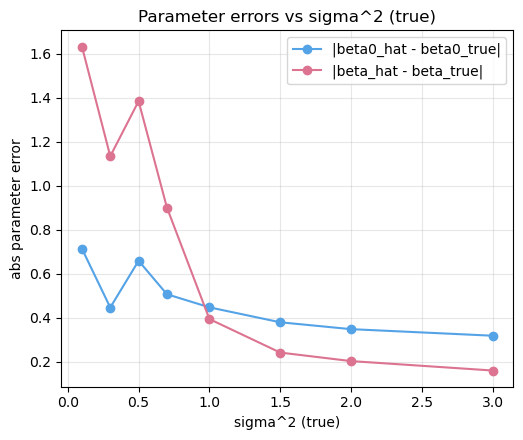

In [ ]:
# ==== sweep sigma^2 and compare *only beta* errors (uses your em_fit_beta as-is) ====
import numpy as np
import matplotlib.pyplot as plt


def gen_data(N, beta0_true, beta_true, sigma2_true, seed=0):
    rng = np.random.default_rng(seed)
    a = rng.normal(size=N)
    pi_true = sigmoid(beta0_true + beta_true * a)
    gamma = rng.binomial(1, pi_true)
    mu_true = np.where(gamma == 1, rng.normal(0, np.sqrt(sigma2_true), size=N), 0.0)
    z = rng.normal(mu_true, 1.0)
    return a, z

def sweep_sigma_beta_only(
    sigma_list, 
    N=500, beta0_true=-0.3, beta_true=1.2,
    seeds=(0,1,2,3),
    beta0_init=0.0, beta_init=0.0, sigma2_init=0.0,
    em_max_iter=400, em_tol=1e-8
):
    records = []
    print("sigma2_true |  |β0-β0*|  |β-β*|   mean(β_hat)  sd(β_hat)   mean(β0_hat)  sd(β0_hat)")
    print("-"*94)
    for s2 in sigma_list:
        b_errs, b0_errs = [], []
        bhats, b0hats = [], []
        for sd in seeds:
            a, z = gen_data(N, beta0_true, beta_true, s2, seed=sd)
            mu_mean, mu_var, w_hat, params_hat = em_fit_beta(
                z, a,
                beta0_init=beta0_init, beta_init=beta_init, sigma2_init=sigma2_init,
                em_max_iter=em_max_iter, em_tol=em_tol
            )
            b0h = float(params_hat['beta0']); bh = float(params_hat['beta'])
            b0hats.append(b0h); bhats.append(bh)
            b0_errs.append(abs(b0h - beta0_true))
            b_errs.append(abs(bh - beta_true))
        rec = {
            "sigma2_true": s2,
            "abs_err_beta0_mean": float(np.mean(b0_errs)),
            "abs_err_beta_mean":  float(np.mean(b_errs)),
            "beta_hat_mean": float(np.mean(bhats)),
            "beta_hat_sd":   float(np.std(bhats, ddof=1)) if len(bhats) > 1 else 0.0,
            "beta0_hat_mean": float(np.mean(b0hats)),
            "beta0_hat_sd":   float(np.std(b0hats, ddof=1)) if len(b0hats) > 1 else 0.0,
        }
        records.append(rec)
        print(f"{s2:11.3f} |  {rec['abs_err_beta0_mean']:7.3f}  {rec['abs_err_beta_mean']:6.3f}   "
              f"{rec['beta_hat_mean']:11.3f}  {rec['beta_hat_sd']:9.3f}   "
              f"{rec['beta0_hat_mean']:11.3f}  {rec['beta0_hat_sd']:9.3f}")
    return records


sigma_grid = np.array([0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0])


recs = sweep_sigma_beta_only(
    sigma_grid,
    N=500, beta0_true=-0.3, beta_true=1.2,
    seeds=(0,1,2,3),
    beta0_init=0.0, beta_init=0.0, sigma2_init=0.0,
    em_max_iter=400, em_tol=1e-8
)


s2s   = np.array([r["sigma2_true"] for r in recs])
err_b = np.array([r["abs_err_beta_mean"] for r in recs])
err_b0= np.array([r["abs_err_beta0_mean"] for r in recs])

beta_hat_mean = np.array([r["beta_hat_mean"] for r in recs])
beta_hat_sd   = np.array([r["beta_hat_sd"]   for r in recs])

plt.figure(figsize=(10,4.5))

plt.subplot(1,2,1)
plt.plot(
    s2s, err_b0, marker="o",
    label="|beta0_hat - beta0_true|",
    color=colors["S"]        # S：浅蓝
)
plt.plot(
    s2s, err_b, marker="o",
    label="|beta_hat - beta_true|",
    color=colors["JS"]       # JS：玫粉
)
plt.xlabel("sigma^2 (true)")
plt.ylabel("abs parameter error")
plt.title("Parameter errors vs sigma^2 (true)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


As $\sigma^2$ increases, both error curves decline overall: the slope parameter $\beta$ improves faster and shows much smaller variance, while the intercept $\beta_0$ improves more slowly with some residual bias.  
The small “dip” at low $\sigma^2$ happens because nudging $\sigma^2$ above (near-)zero expands the variance of the $\gamma=1$ component to $1+\sigma^2$, slightly separating the two components; this makes the E-step responsibilities $w_i$ more informative and reduces error. Minor wiggles in the very small-$\sigma^2$ range reflect sampling noise and EM initialization effects.


### q2

Using the Wald approach: fit your EM model to obtain the MLE $\hat\theta=(\hat\beta_0,\hat\beta,\hat\sigma^2)$

Evaluate the observed log-likelihood $\ell(\theta)=\sum_i \log\!\big[(1-\pi_i)\mathcal N(z_i;0,1)+\pi_i\mathcal N(z_i;0,1+\sigma^2)\big]$ with $\pi_i=\sigma(\beta_0+\beta a_i)$; compute the numerical Hessian at $\hat\theta$ to get the observed information $\mathcal I(\hat\theta)=-\nabla^2\ell(\hat\theta)$, invert it to approximate the covariance so that $\operatorname{SE}(\hat\beta)=\sqrt{[\mathcal I(\hat\theta)^{-1}]_{\beta,\beta}}$, and form the Wald statistic $Z=\hat\beta/\operatorname{SE}(\hat\beta)\sim\mathcal N(0,1)$ (large-sample), yielding a two-sided $p$-value $2(1-\Phi(|Z|))$ for testing $H_0:\beta=0$.


In [ ]:

import numpy as np
from math import erf, sqrt

def loglik_observed(z, a, beta0, beta, sigma2, eps=1e-12):
    def nlogpdf0_var(x, var):
        return -0.5*(np.log(2*np.pi*var) + (x*x)/var)
    eta = beta0 + beta * a
    pi = 1.0 / (1.0 + np.exp(-eta))
    l1 = nlogpdf0_var(z, 1.0 + sigma2) + np.log(pi + eps)
    l0 = nlogpdf0_var(z, 1.0)           + np.log(1.0 - pi + eps)
    m = np.maximum(l1, l0)  # log-sum-exp stabilization
    return float(np.sum(m + np.log(np.exp(l1 - m) + np.exp(l0 - m))))

def _step_for(theta, rel=1e-4, abs_min=1e-6):
    theta = np.asarray(theta, float)
    return np.maximum(abs_min, rel * np.maximum(1.0, np.abs(theta)))

def num_hessian(f, theta, h=None):
    theta = np.asarray(theta, float)
    k = len(theta)
    if h is None:
        h = _step_for(theta)
    H = np.zeros((k, k), dtype=float)
    # Precompute f at shifted points
    for i in range(k):
        ei = np.zeros(k); ei[i] = 1.0
        for j in range(i, k):
            ej = np.zeros(k); ej[j] = 1.0
            fpp = f(theta + h[i]*ei + h[j]*ej)
            fpm = f(theta + h[i]*ei - h[j]*ej)
            fmp = f(theta - h[i]*ei + h[j]*ej)
            fmm = f(theta - h[i]*ei - h[j]*ej)
            H_ij = (fpp - fpm - fmp + fmm) / (4.0 * h[i] * h[j])
            H[i, j] = H_ij
            H[j, i] = H_ij
    return H

def normal_sf(x):
    """Survival function for N(0,1) without scipy."""
    # sf(x) = 0.5 * erfc(x / sqrt(2)) ; use erf
    return 0.5 * (1.0 - erf(x / sqrt(2)))

def wald_test_beta(z, a, em_kwargs=None, h_rel=1e-4):
    """
    Returns: dict(beta_hat, se_beta, Z, p_two_sided, theta_hat, cov)
    """
    em_kwargs = em_kwargs or {}
    # 1) Unconstrained fit
    _, _, _, par = em_fit_beta(z, a, **em_kwargs)
    beta0_hat, beta_hat, s2_hat = float(par['beta0']), float(par['beta']), float(par['sigma2'])

    # 2) Observed log-likelihood at theta; enforce sigma2 > 0 inside f
    def f(theta):
        b0, b, s2 = theta
        s2 = max(1e-8, s2)  # guard boundary
        return loglik_observed(z, a, b0, b, s2)

    theta_hat = np.array([beta0_hat, beta_hat, s2_hat], dtype=float)

    # 3) Numerical Hessian and covariance (inverse of -H)
    h = _step_for(theta_hat, rel=h_rel)
    H = num_hessian(f, theta_hat, h=h)     # ≈ ∇^2 ℓ(θ̂)
    I = -H                                 # observed information
    # Use pinv for stability, then symmetrize
    cov = np.linalg.pinv(I)
    cov = 0.5 * (cov + cov.T)

    # 4) SE(beta), Z, p-value
    var_beta = max(cov[1, 1], 0.0)
    se_beta  = np.sqrt(var_beta) if var_beta > 0 else np.inf
    Z = beta_hat / se_beta if se_beta > 0 else np.sign(beta_hat) * np.inf
    # two-sided p-value without scipy
    p_two = 2.0 * normal_sf(abs(Z))

    return {
        "beta_hat": beta_hat,
        "se_beta": se_beta,
        "Z": Z,
        "p_two_sided": p_two,
        "theta_hat": {"beta0": beta0_hat, "beta": beta_hat, "sigma2": s2_hat},
        "cov": cov
    }


betâ=0.879, SE=0.382, Z=2.30, p(two-sided)=0.02142



=== Summary by beta_true ===
 beta_true  rejection_rate  beta_hat_mean  beta_hat_sd  se_mean  z_mean  p_median
     0.000           0.000          0.211        1.797      inf   0.032     0.795
     0.200           0.020          0.746        3.002      inf   0.209     0.744
     0.400           0.060          1.158        3.640      inf   0.379     0.688
     0.600           0.060          1.481        3.520      inf   0.659     0.474
     0.800           0.080          4.974       22.355      inf   0.836     0.314
     1.000           0.120          5.428       22.355      inf   1.103     0.216
     1.500           0.200          3.077        4.407      inf   1.405     0.173
     2.000           0.300          4.493        6.190      inf   1.534     0.102


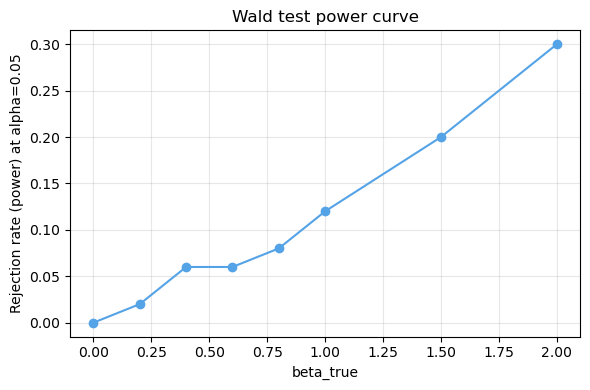

In [217]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, warnings

# --- configuration ---
N = 700
beta0_true = -2
sigma2_true = 1
beta_grid = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5,2])   # change or extend as you like
seeds = list(range(50))                                     # repetitions per beta
alpha = 0.05

warnings.filterwarnings("ignore", category=RuntimeWarning)
# --- run experiments ---
rows = []
for beta_true in beta_grid:
    rejections = 0
    for sd in seeds:
        a, z = gen_data(N, beta0_true, beta_true, sigma2_true, seed=sd)
        out = wald_test_beta(
            z, a,
            em_kwargs=dict(beta0_init=0.0, beta_init=0.0, sigma2_init=1.0, em_max_iter=400, em_tol=1e-8)
        )
        reject = (out["p_two_sided"] < alpha)
        rejections += int(reject)
        rows.append({
            "beta_true": beta_true,
            "seed": sd,
            "beta_hat": out["beta_hat"],
            "SE": out["se_beta"],
            "Z": out["Z"],
            "p": out["p_two_sided"],
            "reject": reject
        })
    # print(f"beta_true={beta_true:.2f} -> rejection rate @ alpha={alpha}: {rejections/len(seeds):.3f}")

df = pd.DataFrame(rows)
# --- aggregate summary per beta_true ---
summary = (
    df.groupby("beta_true")
      .agg(
          rejection_rate=("reject", "mean"),
          beta_hat_mean=("beta_hat", "mean"),
          beta_hat_sd=("beta_hat", "std"),
          se_mean=("SE", "mean"),
          z_mean=("Z", "mean"),
          p_median=("p", "median")
      )
      .reset_index()
)

print("\n=== Summary by beta_true ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# --- optional: plot power curve (rejection rate vs beta_true) ---
plt.figure(figsize=(6,4))
plt.plot(summary["beta_true"], summary["rejection_rate"], marker="o",color=colors["S"] )
plt.xlabel("beta_true")
plt.ylabel("Rejection rate (power) at alpha=0.05")
plt.title("Wald test power curve")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### q3



Let 
$$
q_i = P(\gamma_i = 1 \mid a_i, \beta_0, \beta) = \sigma(\beta_0 + \beta a_i),
\qquad \text{where } \sigma(x) = \frac{1}{1 + e^{-x}}.
$$


 1. Posterior of $\gamma_i$

First, compute the marginal likelihood under each case:
$$
p(z_i \mid \gamma_i = 0) = \mathcal{N}(z_i; 0, 1),
\qquad
p(z_i \mid \gamma_i = 1) = \int \mathcal{N}(z_i; \mu, 1)\,\mathcal{N}(\mu; 0, \sigma^2)\,d\mu 
= \mathcal{N}(z_i; 0, 1 + \sigma^2).
$$

Then, by Bayes' rule, the posterior of $\gamma_i$ given $(z_i, a_i)$ is
$$
P(\gamma_i = 1 \mid z_i, a_i, \beta_0, \beta)
= \frac{\mathcal{N}(z_i; 0, 1 + \sigma^2)\, q_i}
{\mathcal{N}(z_i; 0, 1)\,(1 - q_i) + \mathcal{N}(z_i; 0, 1 + \sigma^2)\, q_i},
$$
and
$$
P(\gamma_i = 0 \mid z_i, a_i, \beta_0, \beta)
= \frac{\mathcal{N}(z_i; 0, 1)\,(1 - q_i)}
{\mathcal{N}(z_i; 0, 1)\,(1 - q_i) + \mathcal{N}(z_i; 0, 1 + \sigma^2)\, q_i}.
$$

 2. Posterior of $\mu_i$

Conditional on $\gamma_i$, we have conjugate normal posteriors.  
When $\gamma_i = 1$:
$$
\mu_i \mid z_i, \gamma_i = 1 \sim \mathcal{N}(m_i, v),
\qquad
v = \frac{\sigma^2}{1 + \sigma^2}, \quad
m_i = \frac{\sigma^2}{1 + \sigma^2} z_i.
$$

When $\gamma_i = 0$, $\mu_i$ is deterministically zero:
$$
\mu_i \mid z_i, \gamma_i = 0 \equiv 0.
$$

Therefore, marginalizing over $\gamma_i$, the full posterior of $\mu_i$ is a mixture:
$$
p(\mu_i \mid z_i, a_i, \beta_0, \beta)
= P(\gamma_i = 1 \mid z_i, a_i, \beta_0, \beta)\,
  \mathcal{N}(\mu_i; m_i, v)
+ P(\gamma_i = 0 \mid z_i, a_i, \beta_0, \beta)\,
  \delta_0(\mu_i).
$$

with $\delta_0$ is the dirac delta function


### q4

In [ ]:


import numpy as np
import matplotlib.pyplot as plt


def gen_data_with_truth(N, beta0_true, beta_true, sigma2_true, seed=0):
    rng = np.random.default_rng(seed)
    a = rng.normal(size=N)
    pi_true = sigmoid(beta0_true + beta_true * a)
    gamma = rng.binomial(1, pi_true)
    mu_true = np.where(gamma == 1, rng.normal(0, np.sqrt(sigma2_true), size=N), 0.0)
    z = rng.normal(mu_true, 1.0)
    return a, z, mu_true


N = 500
sigma2_true = 1.5

beta0_grid = np.linspace(-1.5, 0.5, 9)   
beta_grid  = np.linspace(0.0, 2.5, 9)    
seeds = [0, 1, 2, 3, 4]                  


mse_const = np.zeros((len(beta_grid), len(beta0_grid)), dtype=float)  #
mse_cov   = np.zeros_like(mse_const)


for i_b, beta_true in enumerate(beta_grid):
    for j_b0, beta0_true in enumerate(beta0_grid):
        mses_c, mses_v = [], []
        for sd in seeds:
            a, z, mu_true = gen_data_with_truth(N, beta0_true, beta_true, sigma2_true, seed=sd)


            pi_hat, s2_hat, mu_hat_const = em_spike_slab(
                z, pi_init=0.2, sigma2_init=1.0, tol=1e-8, max_iter=1000
            )


            mu_mean_cov, mu_var_cov, w_cov, params_cov = em_fit_beta(
                z, a, beta0_init=0.0, beta_init=0.0, sigma2_init=1.0,
                em_max_iter=500, em_tol=1e-8
            )

            # MSE
            mses_c.append(np.mean((mu_hat_const - mu_true)**2))
            mses_v.append(np.mean((mu_mean_cov  - mu_true)**2))

        mse_const[i_b, j_b0] = float(np.mean(mses_c))
        mse_cov[i_b, j_b0]   = float(np.mean(mses_v))


mse_diff = mse_cov - mse_const


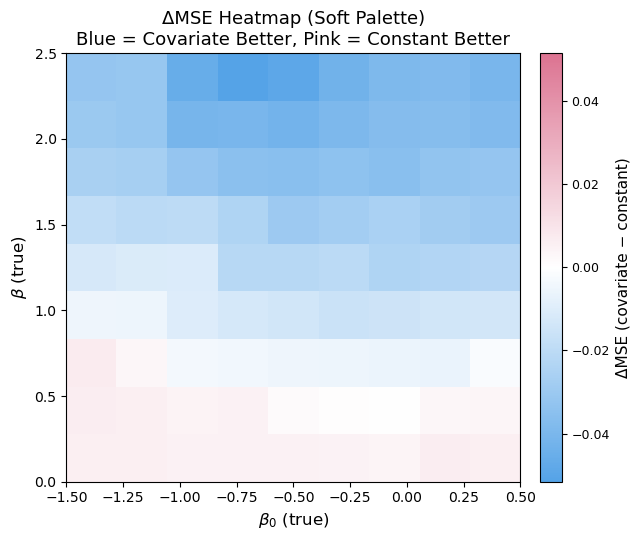

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = ["#55A3E7", "#FFFFFF", "#DC7391"]
soft_cmap = LinearSegmentedColormap.from_list("soft_diff", colors, N=256)


plt.figure(figsize=(6.5,5.5))
dmax = np.max(np.abs(mse_diff))


im = plt.imshow(
    mse_diff, origin="lower", aspect="auto",
    extent=[beta0_grid.min(), beta0_grid.max(),
            beta_grid.min(), beta_grid.max()],
    vmin=-dmax, vmax=dmax, cmap=soft_cmap
)


cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label("ΔMSE (covariate − constant)", fontsize=11)
cb.ax.tick_params(labelsize=9)


plt.xlabel("$\\beta_0$ (true)", fontsize=12)
plt.ylabel("$\\beta$ (true)", fontsize=12)
plt.title("ΔMSE Heatmap (Soft Palette)\nBlue = Covariate Better, Pink = Constant Better",
          fontsize=13, weight='medium')


plt.grid(False)
plt.tight_layout()
plt.show()




This heatmap illustrates how the MSE difference (ΔMSE) between the estimator in (c) and $ \hat{\mu}_i^{S} $ varies with the true parameters ( \beta_0 ) and ( \beta ).

* **Blue areas (negative ΔMSE):** the estimator in (c) achieves lower MSE.
* **Pink areas (positive ΔMSE):** $ \hat{\mu}_i^{S} $ performs slightly better.

As $ \beta $ increases, the plot becomes more blue, indicating that when the covariate has a stronger effect on sparsity, the estimator in (c) provides more accurate estimates of ( \mu ).
When $\beta $ is small, both estimators perform similarly (ΔMSE ≈ 0).


# Problem 2

## Q1
We can solve this problem by EM algorithm

The complete data log-likelihood can be deduced by chain rule
$$
\log p(y,b,\gamma|\sigma^2,\sigma_0^2) = \log p(y|b,\gamma,\sigma^2)+\log p(b|\sigma_0^2)+\log p(\gamma)
$$

with given prior:

$$
\log p(y \mid b, \gamma_i = 1, \sigma^2)
= -\frac{n}{2}\log(2\pi\sigma^2)
  - \frac{1}{2\sigma^2}\|y - b x_i\|^2, \\[1em]
\log p(b \mid \sigma_0^2)
= -\frac{1}{2}\log(2\pi\sigma_0^2)
  - \frac{b^2}{2\sigma_0^2}, \\[1em]
\log p(\gamma_i = 1)
= \log \frac{1}{p}
$$


Thus we can deduce the Q function with latent pramaters $\gamma,b$

$$

Q(\theta\mid\theta^{(t)})=\mathbb{E}_{\gamma,b\mid y,X,\theta^{(t)}}[\cdot]=C-\frac{n}{2}\log\sigma^2-\frac{1}{2\sigma^2}\sum_{i=1}^pr_i^{(t)}｜\mathbb{E}_{b\mid y,\gamma_i}^{(t)}\left[\|y-bx_i\|^2\right]-\frac{1}{2}\log\sigma_0^2-\frac{1}{2\sigma_0^2}\sum_{i=1}^pr_i^{(t)}\mathbb{E}_{b\mid y,\gamma_i}^{(t)}[b^2]
\\
r_i^{(t)} := \mathbb{E}[\gamma_i] = P(\gamma_i=1|y,X,\theta^{(t)})
$$

### E step

By Baysian we have

$$
r_i^{(t)}=\frac{p(y\mid\gamma_i=1,\theta^{(t)})\left.p(\gamma_i=1)\right.}{\sum_{j=1}^pp(y\mid\gamma_j=1,\theta^{(t)})\left.p(\gamma_j=1)\right.}
$$


$$
p(y\mid\gamma_i =1,\theta^{(t)})= \int p(y\mid b,\gamma_i=1,\sigma^2)\mathrm{~}p(b\mid\sigma_0^2)\mathrm{~}db=\mathcal{N}{\left(y;0,\sigma^{2(t)}I+\sigma_0^{2(t)}x_ix_i^\top\right)}
$$

for b，we can dudece
$$

b|y,\gamma_i=1  \sim N(\frac{\sigma_0^{2(t)}x_i^\top y}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i},\frac{\sigma^{2(t)}\sigma_0^{2(t)}}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i})
$$

Hence，the expection part can be 

$$
\mathbb{E}_{b|y,\gamma_i}^{(t)}[b^2]=\left(\frac{\sigma_0^{2(t)}x_i^\top y}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right)^2+\frac{\sigma^{2(t)}\sigma_0^{2(t)}}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}.
$$
$$
\mathbb{E}_{b|y,\gamma_i}^{(t)}[\|y-bx_i\|^2]=\left\|y-x_i\frac{\sigma_0^{2(t)}x_i^\top y}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right\|^2+x_i^\top x_i\frac{\sigma^{2(t)}\sigma_0^{2(t)}}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}.
$$

### M step

Taking derivatives of $Q(\theta|\theta^{(t)})$ and setting them to zero gives:

$$
\begin{gathered}
\sigma^{2(t+1)}=\frac{1}{n}\sum_{i=1}^pr_i^{(t)}\mathbb{E}_{b|y,\gamma_i}^{(t)}[\|y-bx_i\|^2], \\
\sigma_0^{2(t+1)}=\frac{\sum_{i=1}^pr_i^{(t)}\mathbb{E}_{b|y,\gamma_i}^{(t)}[b^2]}{\sum_{i=1}^pr_i^{(t)}}.
\end{gathered}
$$

Thus, we obtain the parameter update formula:
$$
\sigma^{2(t+1)}=\frac{1}{n}\sum_{i=1}^pr_i^{(t)}\left[\left\|y-x_i\frac{\sigma_0^{2(t)}x_i^\top y}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right\|^2+x_i^\top x_i\frac{\sigma^{2(t)}\sigma_0^{2(t)}}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right]
$$

$$
\sigma_0^{2(t+1)}=\frac{\sum_{i=1}^pr_i^{(t)}\left[\left(\frac{\sigma_0^{2(t)}x_i^\top y}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right)^2+\frac{\sigma^{2(t)}\sigma_0^{2(t)}}{\sigma^{2(t)}+\sigma_0^{2(t)}x_i^\top x_i}\right]}{\sum_{i=1}^pr_i^{(t)}}.
$$

## Q2

The posterior distributions are given in E step as follows.
$$
p(b \mid y, \gamma_i = 1, X, \sigma^2, \sigma_0^2)
=\mathcal{
N}\!\left(
\frac{\sigma_0^2 x_i^\top y}
     {\sigma^2 + \sigma_0^2 x_i^\top x_i},
\;
\frac{\sigma^2 \sigma_0^2}
     {\sigma^2 + \sigma_0^2 x_i^\top x_i}
\right).
$$


$$
p(\gamma_i = 1 \mid y, X, \sigma^2, \sigma_0^2)=\frac{
p(y \mid \gamma_i = 1, X, \sigma^2, \sigma_0^2)\,p(\gamma_i = 1)
}{
\sum_{j=1}^p
p(y \mid \gamma_j = 1, X, \sigma^2, \sigma_0^2)\,p(\gamma_j = 1)
},
$$
where
$$
p(y \mid \gamma_i = 1, X, \sigma^2, \sigma_0^2)
=\mathcal{N}{\left(y;0,\sigma^{2}I+\sigma_0^{2}x_ix_i^\top\right)}
$$


# Problem 3

I partly agree with the authors’ viewpoint due to the two main claim:
1. The author’s discussion of shrinkage in Section 3.7 is not particularly accurate.
2. The traditional statistical perspective is powerful, but it does not fully explain AdaBoost’s performance. 



## 1. The author’s discussion of shrinkage in Section 3.7 is not particularly accurate.

In section 3.7, the author claims that it can be observed that shrinkage often does not improve performance and instead can actually cause AdaBoost to overfit in situations where it otherwise would not. However, the decline in the algorithm's performance is not absolute, because whrn changing N, it can be seen that for larger N, shrinkage actually improves the algorithm's performance.

Nevertheless, the phenomenon where shrinkage causes AdaBoost to overfit is indeed observed across different values of N, although it becomes less pronounced as N increases. 



Running for N = 100 ...


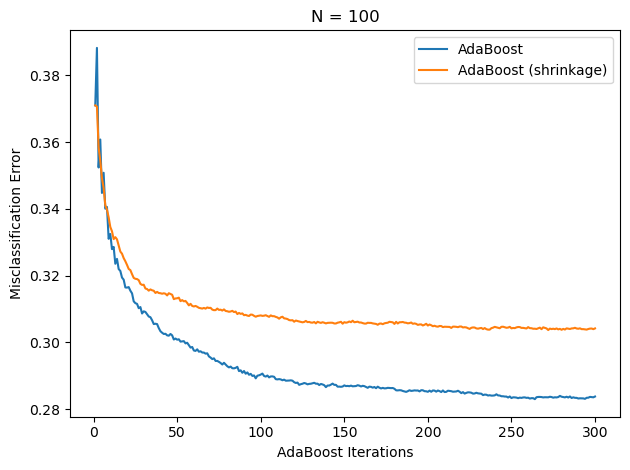


Running for N = 200 ...


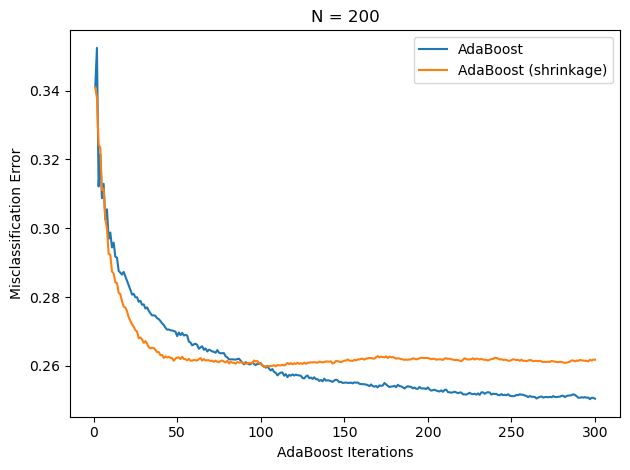


Running for N = 300 ...


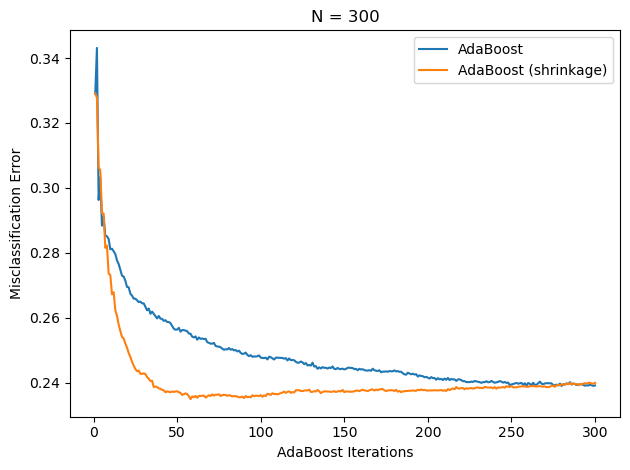


Running for N = 500 ...


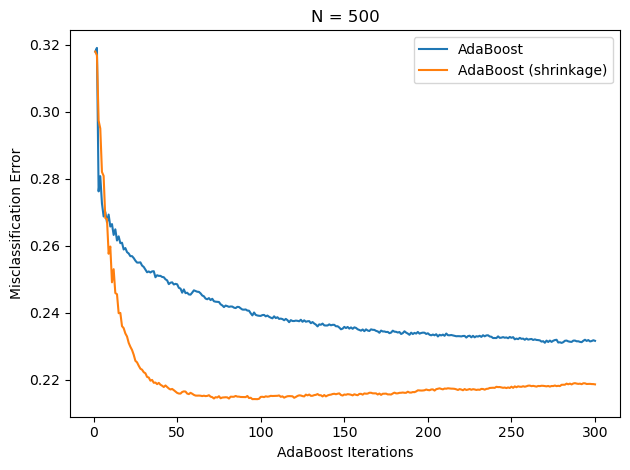


Running for N = 1000 ...


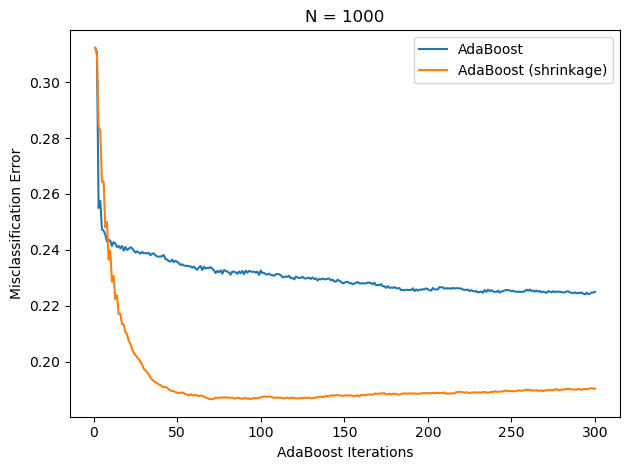

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


# ------------------------
np.random.seed(7777)
Ns = (100,200, 300,500,1000)  
d = 20
J = 5
q = 0.1
iterations = 300
repeat_times = 100
m = 1000  


# ------------------------
def gen_xy(n, d, J, q):
    X = np.random.rand(n, d)
    clean = (X[:, :J].sum(axis=1) > (J / 2)).astype(int)
    flips = (np.random.rand(n) < q).astype(int)
    y = clean ^ flips
    return X, y

def safe_alpha(err, shrink=1.0):
    eps = 1e-12
    e = np.clip(err, eps, 1 - eps)
    return shrink * 0.5 * np.log((1 - e) / e)


for n in Ns:
    print(f"\nRunning for N = {n} ...")
    misclass_store = np.zeros((repeat_times, iterations))
    misclass_shrink_store = np.zeros((repeat_times, iterations))

    for rep in range(repeat_times):
        X, y01 = gen_xy(n, d, J, q)
        X_hold, y_hold01 = gen_xy(m, d, J, q)
        y = 2 * y01 - 1
        y_hold = 2 * y_hold01 - 1

        f = np.zeros(n)
        f_shrink = np.zeros(n)
        hold_f = np.zeros(m)
        hold_f_shrink = np.zeros(m)

        for t in range(iterations):
            # ---- Standard AdaBoost ----
            w = np.exp(-y * f)
            w /= w.sum()
            tree = DecisionTreeClassifier(max_depth=3, random_state=7777)
            tree.fit(X, y, sample_weight=w)
            g = tree.predict(X)
            g_hold = tree.predict(X_hold)
            err = np.sum(w * (g != y))
            a = safe_alpha(err, 1.0)
            f += a * g
            hold_f += a * g_hold
            misclass_store[rep, t] = np.mean((hold_f * y_hold) < 0)

            # ---- Shrinkage AdaBoost ----
            w_s = np.exp(-y * f_shrink)
            w_s /= w_s.sum()
            tree_s = DecisionTreeClassifier(max_depth=3, random_state=7777)
            tree_s.fit(X, y, sample_weight=w_s)
            g_s = tree_s.predict(X)
            g_hold_s = tree_s.predict(X_hold)
            err_s = np.sum(w_s * (g_s != y))
            a_s = safe_alpha(err_s, 0.1)
            f_shrink += a_s * g_s
            hold_f_shrink += a_s * g_hold_s
            misclass_shrink_store[rep, t] = np.mean((hold_f_shrink * y_hold) < 0)


    mean_misclass = misclass_store.mean(axis=0)
    mean_misclass_shrink = misclass_shrink_store.mean(axis=0)

    # ------------------------

    plt.figure()
    plt.plot(
        np.arange(1, iterations + 1),
        mean_misclass,
        label="AdaBoost",
        linewidth=1.5
    )
    plt.plot(
        np.arange(1, iterations + 1),
        mean_misclass_shrink,
        label="AdaBoost (shrinkage)",
        linewidth=1.5
    )
    plt.xlabel("AdaBoost Iterations")
    plt.ylabel("Misclassification Error")
    plt.title(f"N = {n}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 2.the traditional statistical perspective does not fully explain AdaBoost’s performance. 
Here, by “performance,” I am not referring directly to AdaBoost’s resistance to overfitting, since the metric used in the paper is misclassification error. Moreover, the 0–1 loss is a poor diagnostic for overfitting; it is insensitive to margin changes and can remain flat while the model complexity and true risk increase. As shown in **Figure 5** of the original paper, the log of the exponential loss continues to increase.

What I mean by “performance” here is that during continuous iterations, the misclassification error of the 8-node trees does not rise again, as is typical for many other algorithms. For simplicity, I still use the term **“no overfitting”** to describe this phenomenon.

While reading, I also noticed that Friedman, Hastie, and Tibshirani (2008) addressed this issue in their reply paper and conducted several numerical experiments.


> **Friedman J., Hastie T., & Tibshirani R.**  
> *Response to Mease and Wyner, Evidence Contrary to the Statistical View of Boosting*, JMLR 9:131–156, 2008.
> [Link to paper](https://jmlr.csail.mit.edu/papers/volume9/friedman08a/friedman08a.pdf)


There are two main claims in the paper:

1. **Shrinkage (learning rate reduction)** is a beneficial form of regularization.
   It makes boosting behave similarly to a linear model with **L1 regularization**, and it generally improves generalization performance.

2. The phenomenon that **“larger trees outperform stumps” is not universal.**
   While this holds under the original settings, once shrinkage is applied or the sample size increases,
   the combination of **stumps + shrinkage** performs best — consistent with statistical expectations.

The source of these conclusions comes from the two experimental figures below. I didn’t mean to say that these two claims are wrong; rather, I found another interesting phenomenon in Friedman’s experiments.



In [ ]:
# -*- coding: utf-8 -*-
"""
Reproduce the R simulation in Python:
- Data model with Bayes error q
- Hold-out evaluation each boosting iteration
- Compare AdaBoost with stumps (depth=1) vs. 8-node trees (~max_depth=3)
- Also compute Bayes, 1-NN baselines
"""

import numpy as np
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


# --------------------
# Settings (match the R script)
# --------------------
repeat_times = 50
q = 0.1
J = 5
iterations = 1000
n = 200
d = 20
m = 1000  # hold-out size

rng = np.random.default_rng(1111)  # reproducible

# Storage
misclass_store = np.zeros((repeat_times, iterations))
misclass8_store = np.zeros((repeat_times, iterations))
bayeserror_store = np.zeros(repeat_times)
nnerror_store = np.zeros(repeat_times)
# rferror_store = np.zeros(repeat_times)  # left as placeholder, like in R

# --------------------
# Helper: generate one dataset (train + holdout) according to the R code
# --------------------
def gen_dataset(rng, n, m, d, J, q):
    # X ~ U(0,1)^d
    X = rng.uniform(0.0, 1.0, size=(n, d))
    X_hold = rng.uniform(0.0, 1.0, size=(m, d))

    # Label mechanism in R:
    # y[i] <- 1*( runif(1) < ( q + (1-2*q)* 1*( sum(x[i,1:J]) > (J/2) ) ) )
    # i.e., with prob q we flip the Bayes rule, else follow the threshold on sum of first J features
    def sample_labels(U, q, J):
        # Bayes rule (without noise): 1{ sum(first J) > J/2 }
        bayes = (np.sum(U[:, :J], axis=1) > (J/2)).astype(int)
        noise = rng.uniform(0.0, 1.0, size=U.shape[0]) < q
        y = bayes.copy()
        # flip label where noise==True
        y[noise] = 1 - y[noise]
        return y, bayes

    y, _ = sample_labels(X, q, J)
    y_hold, bayes_hold = sample_labels(X_hold, q, J)
    return X, y, X_hold, y_hold, bayes_hold

#     # function to train one stump / small tree with sample weights and return g(x) in {-1,+1}

def fit_tree_and_predict(Xtr, ytr_pm1, sample_w, Xte, max_depth):
    # sklearn wants classes as {0,1} or {-1,1} both OK; we’ll pass {-1,+1}
    # Use max_depth=1 for stump; ~3 for "8-node" (binary tree up to 8 leaves)
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rep  # slight determinism per repetition
    )
    clf.fit(Xtr, ytr_pm1, sample_weight=sample_w)

    # Predict as probabilities to mimic R code's argmax over two classes
    # If the tree never sees one of the classes due to weights, predict_proba may have 1 column.
    # So we fall back to decision_function/sign where needed.
    try:
        proba_tr = clf.predict_proba(Xtr)
        proba_te = clf.predict_proba(Xte)
        # Map to {-1,+1} by argmax (class order = clf.classes_)
        # Ensure class mapping aligns with {-1,+1}
        classes = clf.classes_
        # Take index of the positive (+1) class if present
        if -1 in classes and 1 in classes:
            idx_pos = np.where(classes == 1)[0][0]
            idx_neg = np.where(classes == -1)[0][0]
            g_tr = np.where(proba_tr[:, idx_pos] >= proba_tr[:, idx_neg], 1, -1)
            g_te = np.where(proba_te[:, idx_pos] >= proba_te[:, idx_neg], 1, -1)
        else:
            # Degenerate: only one class present; predict that class
            only = classes[0]
            g_tr = np.full(Xtr.shape[0], only, dtype=int)
            g_te = np.full(Xte.shape[0], only, dtype=int)
    except Exception:
        # Fallback: use sign of decision function or of predictions
        if hasattr(clf, "decision_path"):
            g_tr = clf.predict(Xtr)
            g_te = clf.predict(Xte)
        else:
            g_tr = np.sign(clf.predict(Xtr))
            g_te = np.sign(clf.predict(Xte))
        g_tr[g_tr == 0] = 1
        g_te[g_te == 0] = 1

    return g_tr.astype(int), g_te.astype(int)


# --------------------
# Main simulation (add shrinkage)
# --------------------
nus = [1.0, 0.1]  # 1.0 = no shrinkage; 0.1 = shrinkage
labels_for_nu = {1.0: "", 0.1: " shrunk 0.1"}


mis_curves = {nu: {"stump": np.zeros((repeat_times, iterations)),
                   "tree":  np.zeros((repeat_times, iterations))}
              for nu in nus}

bayeserror_store = np.zeros(repeat_times)
nnerror_store = np.zeros(repeat_times)

for rep in range(repeat_times):
    X, y01, Xh, yh01, bayes_hold = gen_dataset(rng, n, m, d, J, q)


    bayes_pred = bayes_hold
    bayeserror_store[rep] = 1.0 - np.mean(bayes_pred == yh01)
    knn = KNeighborsClassifier(n_neighbors=1).fit(X, y01)
    nnerror_store[rep] = 1.0 - np.mean(knn.predict(Xh) == yh01)


    y  = -1 + 2 * y01
    yh = -1 + 2 * yh01


    state = {}
    for nu in nus:
        state[nu] = {
            "f_stump": np.zeros(n),
            "f_tree":  np.zeros(n),
            "fh_stump": np.zeros(m),
            "fh_tree":  np.zeros(m),
        }


    for t in range(iterations):
        for nu in nus:
            f_stump = state[nu]["f_stump"]
            f_tree  = state[nu]["f_tree"]

            w_stump = np.exp(-y * f_stump)
            w_tree  = np.exp(-y * f_tree)
            w_stump /= np.sum(w_stump)
            w_tree  /= np.sum(w_tree)


            g_tr_s, g_te_s = fit_tree_and_predict(X, y, w_stump, Xh, max_depth=1)
            g_tr_8, g_te_8 = fit_tree_and_predict(X, y, w_tree,  Xh, max_depth=3)


            eps = 1e-12
            e_s = np.clip(np.sum(w_stump * (y != g_tr_s)), eps, 1 - eps)
            e_8 = np.clip(np.sum(w_tree  * (y != g_tr_8)), eps, 1 - eps)
            alpha_s = 0.5 * math.log((1 - e_s) / e_s)
            alpha_8 = 0.5 * math.log((1 - e_8) / e_8)


            f_stump += (nu * alpha_s) * g_tr_s
            f_tree  += (nu * alpha_8) * g_tr_8
            state[nu]["f_stump"] = f_stump
            state[nu]["f_tree"]  = f_tree


            state[nu]["fh_stump"] += (nu * alpha_s) * g_te_s
            state[nu]["fh_tree"]  += (nu * alpha_8) * g_te_8


            mis_s = np.mean((state[nu]["fh_stump"] * yh) < 0)
            mis_8 = np.mean((state[nu]["fh_tree"]  * yh) < 0)
            mis_curves[nu]["stump"][rep, t] = mis_s
            mis_curves[nu]["tree"][rep,  t] = mis_8

# --------------------
# Averages across repetitions
# --------------------
mean_no_shrink_stump = mis_curves[1.0]["stump"].mean(axis=0)
mean_no_shrink_tree  = mis_curves[1.0]["tree"].mean(axis=0)
mean_shrink_stump    = mis_curves[0.1]["stump"].mean(axis=0)
mean_shrink_tree     = mis_curves[0.1]["tree"].mean(axis=0)



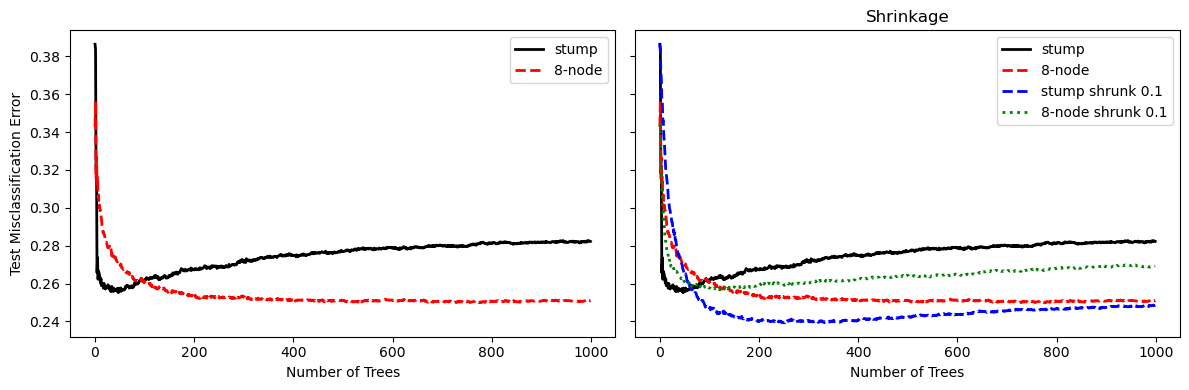

In [279]:
# --------------------
# Plot (left: no shrink; right: add ν=0.1 curves)
# --------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# 左图：无 shrinkage
ax[0].plot(mean_no_shrink_stump, color='k',  lw=2, label='stump')
ax[0].plot(mean_no_shrink_tree,  color='r',  lw=2, ls='--', label='8-node')
ax[0].set_title('')
ax[0].set_xlabel('Number of Trees')
ax[0].set_ylabel('Test Misclassification Error')
ax[0].legend(loc='upper right')

# 右图：含 shrinkage
ax[1].plot(mean_no_shrink_stump, color='k',  lw=2, label='stump')
ax[1].plot(mean_no_shrink_tree,  color='r',  lw=2, ls='--', label='8-node')
ax[1].plot(mean_shrink_stump,    color='b',  lw=2, ls='--', label='stump shrunk 0.1')
ax[1].plot(mean_shrink_tree,     color='g',  lw=2, ls=':',  label='8-node shrunk 0.1')
ax[1].set_title('Shrinkage')
ax[1].set_xlabel('Number of Trees')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


Friedman et al.’s experiments show that after introducing shrinkage (learning-rate reduction), stumps outperform 8-node trees. What I find more interesting, however, is this: although shrinkage improves the misclassification error for both stumps and 8-node trees, it also leads to pronounced overfitting—and this overfitting appears in both models. Notably, without shrinkage, the training error of the 8-node trees does not begin to rise the way it does for the other trees. 


Based on the overfitting phenomenon we observed, I attempted to further increase the number of iterations. (From Figure 1, we can see that when the sample size is relatively large, the overfitting phenomenon may disappear or become much less noticeable, so here \( N = 200 \) is fixed. In fact, in Friedman’s response, the case of \( N = 2000 \) was examined, and it can be clearly seen in the figure that the overfitting phenomenon appears in trees other than the 8-node tree.)


In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


# --------------------
# Settings (match the R script)
# --------------------
repeat_times = 40
q = 0.1
J = 5
iterations = 10000
n = 200
d = 20
m = 1000  # hold-out size

rng = np.random.default_rng(1111)  # reproducible

# Storage
misclass_store = np.zeros((repeat_times, iterations))
misclass8_store = np.zeros((repeat_times, iterations))
bayeserror_store = np.zeros(repeat_times)
nnerror_store = np.zeros(repeat_times)
# rferror_store = np.zeros(repeat_times)  # left as placeholder, like in R

# --------------------
# Helper: generate one dataset (train + holdout) according to the R code
# --------------------
def gen_dataset(rng, n, m, d, J, q):
    # X ~ U(0,1)^d
    X = rng.uniform(0.0, 1.0, size=(n, d))
    X_hold = rng.uniform(0.0, 1.0, size=(m, d))

    # Label mechanism in R:
    # y[i] <- 1*( runif(1) < ( q + (1-2*q)* 1*( sum(x[i,1:J]) > (J/2) ) ) )
    # i.e., with prob q we flip the Bayes rule, else follow the threshold on sum of first J features
    def sample_labels(U, q, J):
        # Bayes rule (without noise): 1{ sum(first J) > J/2 }
        bayes = (np.sum(U[:, :J], axis=1) > (J/2)).astype(int)
        noise = rng.uniform(0.0, 1.0, size=U.shape[0]) < q
        y = bayes.copy()
        # flip label where noise==True
        y[noise] = 1 - y[noise]
        return y, bayes

    y, _ = sample_labels(X, q, J)
    y_hold, bayes_hold = sample_labels(X_hold, q, J)
    return X, y, X_hold, y_hold, bayes_hold

#     # function to train one stump / small tree with sample weights and return g(x) in {-1,+1}

def fit_tree_and_predict(Xtr, ytr_pm1, sample_w, Xte, max_depth):
    # sklearn wants classes as {0,1} or {-1,1} both OK; we’ll pass {-1,+1}
    # Use max_depth=1 for stump; ~3 for "8-node" (binary tree up to 8 leaves)
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rep  # slight determinism per repetition
    )
    clf.fit(Xtr, ytr_pm1, sample_weight=sample_w)

    # Predict as probabilities to mimic R code's argmax over two classes
    # If the tree never sees one of the classes due to weights, predict_proba may have 1 column.
    # So we fall back to decision_function/sign where needed.
    try:
        proba_tr = clf.predict_proba(Xtr)
        proba_te = clf.predict_proba(Xte)
        # Map to {-1,+1} by argmax (class order = clf.classes_)
        # Ensure class mapping aligns with {-1,+1}
        classes = clf.classes_
        # Take index of the positive (+1) class if present
        if -1 in classes and 1 in classes:
            idx_pos = np.where(classes == 1)[0][0]
            idx_neg = np.where(classes == -1)[0][0]
            g_tr = np.where(proba_tr[:, idx_pos] >= proba_tr[:, idx_neg], 1, -1)
            g_te = np.where(proba_te[:, idx_pos] >= proba_te[:, idx_neg], 1, -1)
        else:
            # Degenerate: only one class present; predict that class
            only = classes[0]
            g_tr = np.full(Xtr.shape[0], only, dtype=int)
            g_te = np.full(Xte.shape[0], only, dtype=int)
    except Exception:
        # Fallback: use sign of decision function or of predictions
        if hasattr(clf, "decision_path"):
            g_tr = clf.predict(Xtr)
            g_te = clf.predict(Xte)
        else:
            g_tr = np.sign(clf.predict(Xtr))
            g_te = np.sign(clf.predict(Xte))
        g_tr[g_tr == 0] = 1
        g_te[g_te == 0] = 1

    return g_tr.astype(int), g_te.astype(int)


# --------------------
# Main simulation (add shrinkage)
# --------------------
nus = [1.0, 0.1]  # 1.0 = no shrinkage; 0.1 = shrinkage
labels_for_nu = {1.0: "", 0.1: " shrunk 0.1"}


mis_curves = {nu: {"stump": np.zeros((repeat_times, iterations)),
                   "tree":  np.zeros((repeat_times, iterations))}
              for nu in nus}

bayeserror_store = np.zeros(repeat_times)
nnerror_store = np.zeros(repeat_times)

for rep in range(repeat_times):
    X, y01, Xh, yh01, bayes_hold = gen_dataset(rng, n, m, d, J, q)


    bayes_pred = bayes_hold
    bayeserror_store[rep] = 1.0 - np.mean(bayes_pred == yh01)
    knn = KNeighborsClassifier(n_neighbors=1).fit(X, y01)
    nnerror_store[rep] = 1.0 - np.mean(knn.predict(Xh) == yh01)


    y  = -1 + 2 * y01
    yh = -1 + 2 * yh01


    state = {}
    for nu in nus:
        state[nu] = {
            "f_stump": np.zeros(n),
            "f_tree":  np.zeros(n),
            "fh_stump": np.zeros(m),
            "fh_tree":  np.zeros(m),
        }


    for t in range(iterations):
        for nu in nus:
            f_stump = state[nu]["f_stump"]
            f_tree  = state[nu]["f_tree"]


            w_stump = np.exp(-y * f_stump)
            w_tree  = np.exp(-y * f_tree)
            w_stump /= np.sum(w_stump)
            w_tree  /= np.sum(w_tree)


            g_tr_s, g_te_s = fit_tree_and_predict(X, y, w_stump, Xh, max_depth=1)
            g_tr_8, g_te_8 = fit_tree_and_predict(X, y, w_tree,  Xh, max_depth=3)


            eps = 1e-12
            e_s = np.clip(np.sum(w_stump * (y != g_tr_s)), eps, 1 - eps)
            e_8 = np.clip(np.sum(w_tree  * (y != g_tr_8)), eps, 1 - eps)
            alpha_s = 0.5 * math.log((1 - e_s) / e_s)
            alpha_8 = 0.5 * math.log((1 - e_8) / e_8)

        
            f_stump += (nu * alpha_s) * g_tr_s
            f_tree  += (nu * alpha_8) * g_tr_8
            state[nu]["f_stump"] = f_stump
            state[nu]["f_tree"]  = f_tree


            state[nu]["fh_stump"] += (nu * alpha_s) * g_te_s
            state[nu]["fh_tree"]  += (nu * alpha_8) * g_te_8

            mis_s = np.mean((state[nu]["fh_stump"] * yh) < 0)
            mis_8 = np.mean((state[nu]["fh_tree"]  * yh) < 0)
            mis_curves[nu]["stump"][rep, t] = mis_s
            mis_curves[nu]["tree"][rep,  t] = mis_8

# --------------------
# Averages across repetitions
# --------------------
mean_no_shrink_stump = mis_curves[1.0]["stump"].mean(axis=0)
mean_no_shrink_tree  = mis_curves[1.0]["tree"].mean(axis=0)
mean_shrink_stump    = mis_curves[0.1]["stump"].mean(axis=0)
mean_shrink_tree     = mis_curves[0.1]["tree"].mean(axis=0)



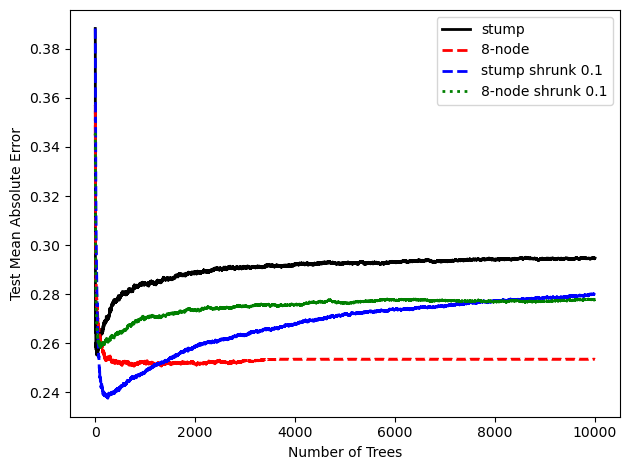

In [290]:
fig, ax = plt.subplots()

ax.plot(mean_no_shrink_stump, color='k', lw=2, label='stump')
ax.plot(mean_no_shrink_tree,  color='r', lw=2, ls='--', label='8-node')
ax.plot(mean_shrink_stump,    color='b', lw=2, ls='--', label='stump shrunk 0.1')
ax.plot(mean_shrink_tree,     color='g', lw=2, ls=':',  label='8-node shrunk 0.1')


ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Mean Absolute Error')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()



# Problem 4

I think this claim very convincing. The authors provided detailed experimental evidence in support of their argument, including but not limited to validations involving DoF, SNR, and noise-added real datasets. Therefore, I would like to conduct some extended experiments based on their work to further illustrate the characteristics and underlying ideas of the random forest model.

## Different Data Generation Methods

This part simulate periodic, harmonically structured regression data by synthesizing exponentially decayed sinusoidal tones with vibrato modulation, summed into a chord-like signal plus rhythmic beats. Gaussian noise is then added to achieve a specified signal-to-noise ratio (SNR), defined as

$$
SNR = \frac{Var(f(x))}{Var(\delta)}
$$
This formulation allows controlled transitions from high- to low-SNR regimes for robustness analysis.

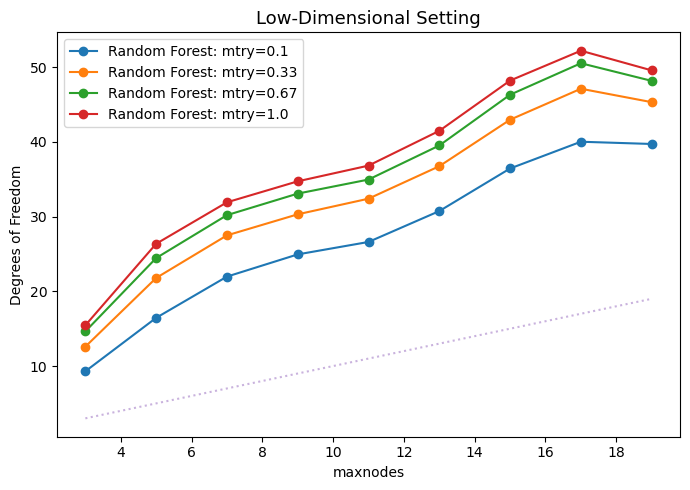

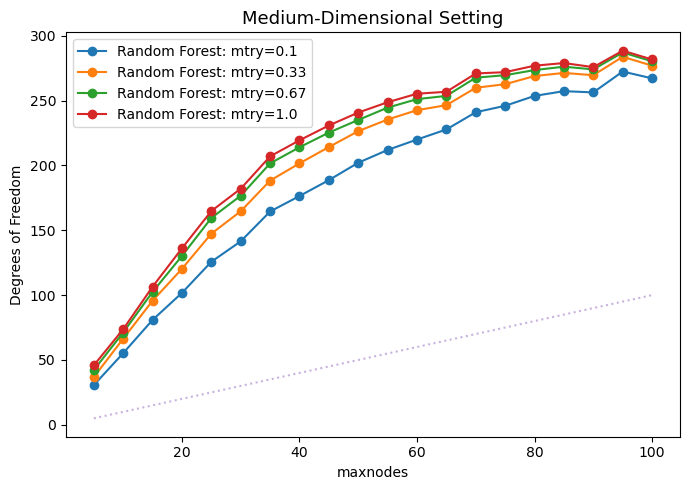

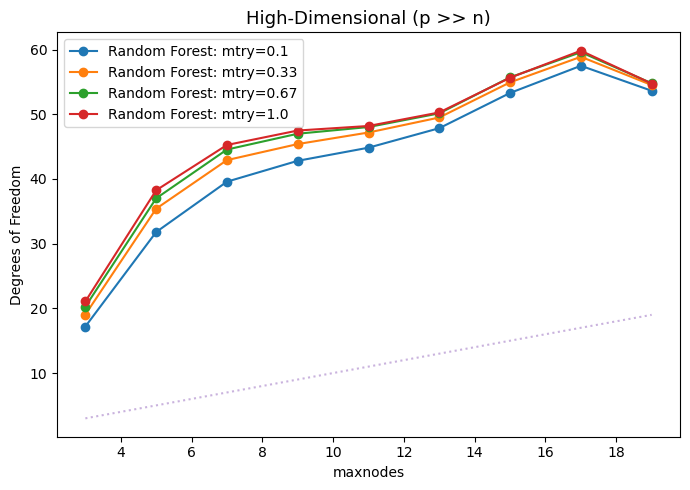

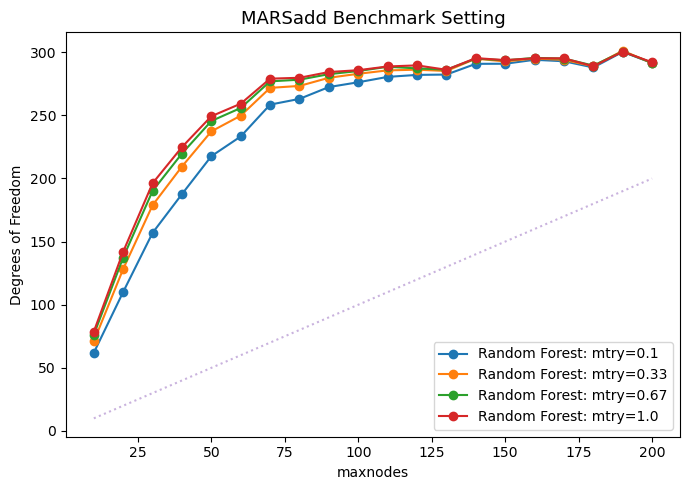

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_random_state

# ---------- MUSIC-style generator (linear SNR) ----------
def generate_music_data(n_samples=1000, n_notes=8, tempo=120, snr=3.52,
                        random_state=None, return_components=False):
    rng = np.random.default_rng(random_state)
    t = np.linspace(0.0, 4.0, n_samples, endpoint=False)

    X = np.zeros((n_samples, n_notes), dtype=float)
    freqs = [220.0 * (2.0 ** (i / 12.0)) for i in range(n_notes)]
    for i, f0 in enumerate(freqs):
        envelope = np.exp(-0.5 * t)
        vibrato = 0.1 * np.sin(2 * np.pi * 5.0 * t)
        X[:, i] = envelope * np.sin(2 * np.pi * (f0 + vibrato) * t)

    chord_indices = [0, 2, 4] if n_notes >= 5 else list(range(min(3, n_notes)))
    y_signal = X[:, chord_indices].sum(axis=1)

    beat_freq = tempo / 60.0
    drum = 0.3 * (np.sin(2 * np.pi * beat_freq * t) > 0.9).astype(float)
    y_signal = y_signal + drum

    sig_var = float(np.var(y_signal))
    sigma2 = sig_var / snr
    sigma = np.sqrt(sigma2)
    noise = rng.normal(0.0, sigma, size=n_samples)
    y = y_signal + noise

    return (X, y, y_signal, sigma) if return_components else (X, y)


# ---------- Degrees of freedom estimator ----------
def estimate_dof_rf_music(n_samples, n_notes, snr, tempo,
                          maxnodes_grid, mtry, n_trees=200, R=50, random_state=0):
    rng = check_random_state(random_state)
    X, _, y_signal, sigma = generate_music_data(
        n_samples=n_samples, n_notes=n_notes, tempo=tempo, snr=snr,
        random_state=rng.randint(1_000_000), return_components=True
    )
    n = X.shape[0]
    sigma2 = float(sigma**2)

    dof_curve = []
    for maxnodes in maxnodes_grid:
        Y = np.zeros((R, n))
        Yhat = np.zeros((R, n))
        for r in range(R):
            eps = rng.normal(0.0, sigma, size=n)
            y = y_signal + eps
            Y[r, :] = y

            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_features=mtry,
                max_leaf_nodes=maxnodes,
                bootstrap=True,
                n_jobs=-1,
                random_state=rng.randint(1_000_000),
            )
            rf.fit(X, y)
            Yhat[r, :] = rf.predict(X)

        y_mean = Y.mean(axis=0)
        yhat_mean = Yhat.mean(axis=0)
        cov_i = ((Y - y_mean) * (Yhat - yhat_mean)).mean(axis=0)
        dof = (1.0 / sigma2) * np.sum(cov_i)
        dof_curve.append((maxnodes, float(dof)))
    return dof_curve


# ---------- Experiment settings ----------
SNR = 3.52
TEMPO = 120

maxnodes_grids = {
    'Low-Dimensional Setting':      list(range(3, 21, 2)),
    'Medium-Dimensional Setting':   list(range(5, 101, 5)),
    'High-Dimensional (p >> n)':    list(range(3, 21, 2)),
    'MARSadd Benchmark Setting':    list(range(10, 201, 10)),
}

size_specs = {
    'Low-Dimensional Setting':      dict(n_samples=100,  n_notes=10),
    'Medium-Dimensional Setting':   dict(n_samples=500,  n_notes=100),
    'High-Dimensional (p >> n)':    dict(n_samples=100,  n_notes=1000),
    'MARSadd Benchmark Setting':    dict(n_samples=500,  n_notes=200),
}

mtry_list = [0.1, 0.33, 0.67, 1.0]
N_TREES = 200
R_REPS = 15
RANDOM_SEED = 2025


plt.ion()

for panel, spec in size_specs.items():
    grid = maxnodes_grids[panel]

    fig, ax = plt.subplots(figsize=(7, 5))
    for mtry in mtry_list:
        curve = estimate_dof_rf_music(
            n_samples=spec['n_samples'],
            n_notes=spec['n_notes'],
            snr=SNR,
            tempo=TEMPO,
            maxnodes_grid=grid,
            mtry=mtry,
            n_trees=N_TREES,
            R=R_REPS,
            random_state=RANDOM_SEED
        )
        xs = [k for k, _ in curve]
        ys = [v for _, v in curve]
        ax.plot(xs, ys, marker='o', label=f"Random Forest: mtry={mtry}")

    ax.plot([grid[0], grid[-1]], [grid[0], grid[-1]], linestyle=':', alpha=0.5)
    ax.set_title(panel, fontsize=13)
    ax.set_xlabel("maxnodes")
    ax.set_ylabel("Degrees of Freedom")
    ax.legend(loc="best")

    fig.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)

plt.ioff()



Running experiments over different SNRs...
SNR=0.05  Δ=0.4711
SNR=0.10  Δ=0.0826
SNR=0.20  Δ=0.0780
SNR=0.50  Δ=-0.0061
SNR=1.00  Δ=-0.0235
SNR=2.00  Δ=-0.0222


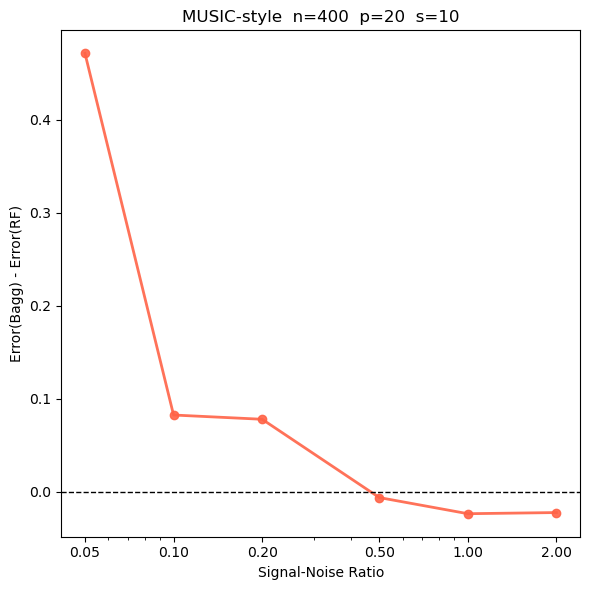

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_random_state



def generate_music_data(n_samples=1000, n_notes=100, s_active=5,
                        tempo=120, snr=3.52, random_state=None):
    rng = np.random.default_rng(random_state)
    t = np.linspace(0.0, 4.0, n_samples, endpoint=False)

    X = np.zeros((n_samples, n_notes))
    freqs = [220.0 * (2.0 ** (i / 12.0)) for i in range(n_notes)]
    for i, f0 in enumerate(freqs):
        envelope = np.exp(-0.5 * t)
        vibrato = 0.1 * np.sin(2 * np.pi * 5.0 * t)
        X[:, i] = envelope * np.sin(2 * np.pi * (f0 + vibrato) * t)

    act_idx = list(range(min(s_active, n_notes)))
    y_signal = X[:, act_idx].sum(axis=1)

    beat_freq = tempo / 60.0
    drum = 0.3 * (np.sin(2 * np.pi * beat_freq * t) > 0.9).astype(float)
    y_signal = y_signal + drum

    sig_var = np.var(y_signal)
    sigma2 = sig_var / snr
    sigma = np.sqrt(sigma2)
    noise = rng.normal(0.0, sigma, size=n_samples)
    y = y_signal + noise
    return X, y



def eval_bagg_vs_rf_once(n=500, p=100, s=5, snr=3.52, tempo=120,
                         n_trees=120, mtry_rf=0.33, random_state=0):
    """单次比较 Bagging 和 RandomForest 的测试 MSE"""
    rng = check_random_state(random_state)
    X, y = generate_music_data(n_samples=n, n_notes=p, s_active=s,
                               tempo=tempo, snr=snr,
                               random_state=rng.randint(1_000_000))

    # train/test 
    idx = rng.permutation(n)
    n_test = n // 2
    Xtr, Xte = X[idx[n_test:]], X[idx[:n_test]]
    ytr, yte = y[idx[n_test:]], y[idx[:n_test]]

    # Bagging（max_features=1.0）
    bagg = RandomForestRegressor(
        n_estimators=n_trees,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=rng.randint(1_000_000)
    )
    bagg.fit(Xtr, ytr)
    err_bagg = np.mean((bagg.predict(Xte) - yte) ** 2)

    # Random Forest（max_features < 1）
    rf = RandomForestRegressor(
        n_estimators=n_trees,
        max_features=mtry_rf,
        bootstrap=True,
        n_jobs=-1,
        random_state=rng.randint(1_000_000)
    )
    rf.fit(Xtr, ytr)
    err_rf = np.mean((rf.predict(Xte) - yte) ** 2)

    return err_bagg, err_rf



def main():
    rng = np.random.default_rng(2025)

    SNR_GRID = [0.05,0.1,0.2,0.5,1.0,2.0]
    n, p, s = 400, 20, 10
    N_TREES = 120
    MTRY_RF = 0.33
    R_REPS = 30

    diff_list = []

    print("Running experiments over different SNRs...")
    for snr in SNR_GRID:
        errs = [eval_bagg_vs_rf_once(n=n, p=p, s=s, snr=snr,
                                     n_trees=N_TREES, mtry_rf=MTRY_RF,
                                     random_state=rng.integers(1_000_000))
                for _ in range(R_REPS)]
        err_bagg = np.mean([e[0] for e in errs])
        err_rf = np.mean([e[1] for e in errs])
        diff = err_bagg - err_rf
        diff_list.append(diff)
        print(f"SNR={snr:.2f}  Δ={diff:.4f}")


    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(SNR_GRID, diff_list, marker='o', color='tomato', linewidth=2, alpha=0.9)
    ax.axhline(0.0, linestyle='--', color='k', linewidth=1)
    ax.set_xlabel("Signal-Noise Ratio")
    ax.set_ylabel("Error(Bagg) - Error(RF)")
    ax.set_title(f"MUSIC-style  n={n}  p={p}  s={s}")
    ax.set_xscale('log')  
    ax.set_xticks(SNR_GRID)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='x')
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


The results of the new data model show slight fluctuations, possibly due to the influence of numerical experiments and the more complex data structure with weaker additivity. However, the overall trend of the summarized results aligns with the conclusions presented in the paper.

## Extending Random Feature Selection 
If the regularization effect originates from randomness itself, this mechanism should extend beyond decision trees. In Section 5 of the paper, the authors designed a “random forward selection” experiment, introducing similar randomness into a linear model. The randomized linear model performed remarkably well under low SNR, even outperforming explicit regularization methods such as Lasso. This demonstrates that the regularization benefit arises from randomness rather than any tree-specific property. Building on this insight, I plan to extend this idea of randomized feature selection to other methods—specifically, to explore the regularization effect of randomness in randomized k-NN.

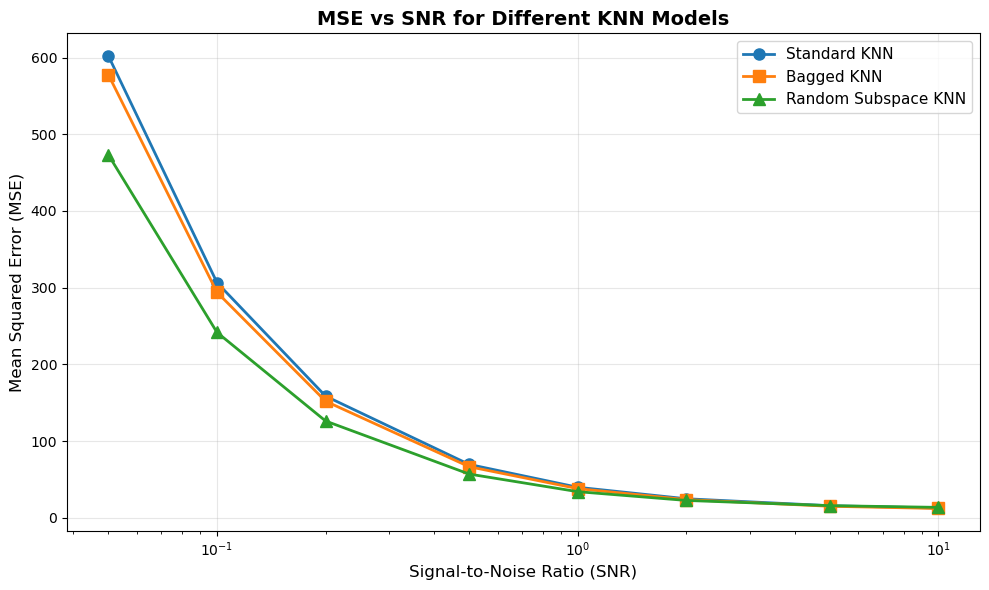

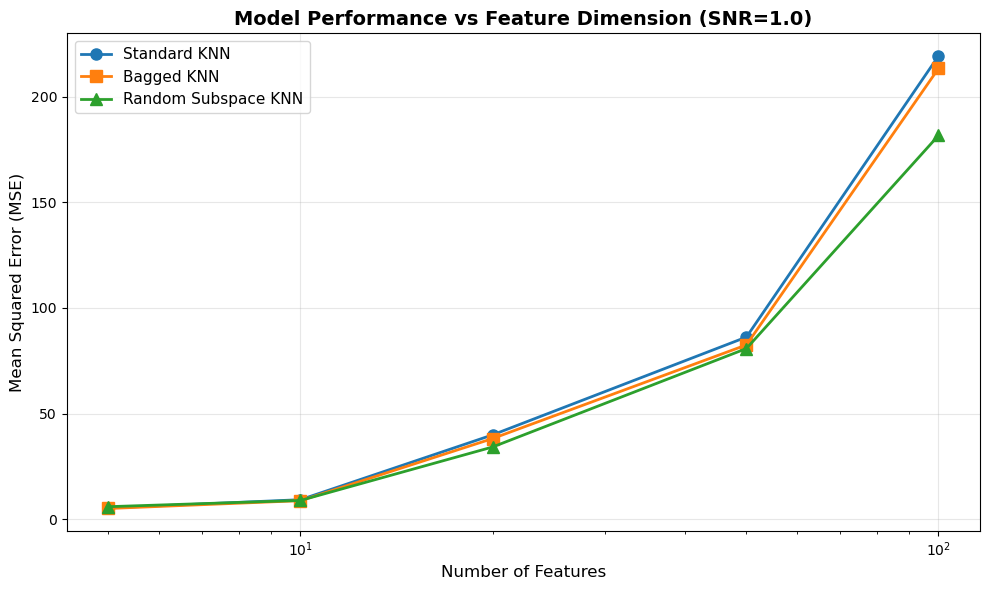

{'Standard KNN': {'MSE': [5.353059679246602,
   9.265834700741975,
   39.919407450949784,
   86.20269774532328,
   219.19405971374172]},
 'Bagged KNN': {'MSE': [5.101412149030424,
   8.800618709297467,
   38.17981684344074,
   82.49368840373818,
   213.2825013312379]},
 'Random Subspace KNN': {'MSE': [5.960363303949463,
   8.907174663266227,
   34.18809596622977,
   80.77933419369488,
   181.5828906740248]}}

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

class RandomSubspaceKNN(BaseEstimator):
    def __init__(self, n_estimators=100, subspace_ratio=0.5, n_neighbors=5, 
                 random_state=None):
        self.n_estimators = n_estimators
        self.subspace_ratio = subspace_ratio
        self.n_neighbors = n_neighbors
        self.random_state = random_state
        self.estimators_ = []
        self.feature_masks_ = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_features_ = n_features
        subspace_size = max(1, int(n_features * self.subspace_ratio))
        
        np.random.seed(self.random_state)
        
        for i in range(self.n_estimators):
            feature_mask = np.random.choice(n_features, subspace_size, replace=False)
            self.feature_masks_.append(feature_mask)
            
            knn = KNeighborsRegressor(n_neighbors=self.n_neighbors)
            X_sub = X[:, feature_mask]
            knn.fit(X_sub, y)
            self.estimators_.append(knn)
            
        return self
    
    def predict(self, X):
        predictions = []
        
        for i, estimator in enumerate(self.estimators_):
            feature_mask = self.feature_masks_[i]
            X_sub = X[:, feature_mask]
            pred = estimator.predict(X_sub)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)

class BaggedKNN(BaseEstimator):
    def __init__(self, n_estimators=100, n_neighbors=5, random_state=None):
        self.n_estimators = n_estimators
        self.n_neighbors = n_neighbors
        self.random_state = random_state
        self.estimators_ = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        for i in range(self.n_estimators):
            X_boot, y_boot = resample(X, y, random_state=self.random_state + i)
            knn = KNeighborsRegressor(n_neighbors=self.n_neighbors)
            knn.fit(X_boot, y_boot)
            self.estimators_.append(knn)
            
        return self
    
    def predict(self, X):
        predictions = []
        for estimator in self.estimators_:
            pred = estimator.predict(X)
            predictions.append(pred)
            
        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)

def generate_data_with_snr(n_samples=1000, n_features=20, snr=1.0, random_state=42):
    """生成具有特定信噪比(SNR)的数据"""
    np.random.seed(random_state)
    
    X = np.random.randn(n_samples, n_features)
    beta = np.random.randn(n_features)
    signal = X @ beta
    signal_variance = np.var(signal)
    noise_variance = signal_variance / snr
    noise = np.random.randn(n_samples) * np.sqrt(noise_variance)
    y = signal + noise
    
    return X, y, beta


def plot_mse_vs_snr(snr_values=[0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0], 
                   n_samples=1000, n_features=20, 
                   n_estimators=50, n_neighbors=5):
    """绘制MSE随SNR变化的曲线"""
    
    results = {
        'Standard KNN': {'MSE': []},
        'Bagged KNN': {'MSE': []},
        'Random Subspace KNN': {'MSE': []}
    }
    
    for snr in snr_values:
        X, y, beta = generate_data_with_snr(n_samples=n_samples, n_features=n_features, 
                                          snr=snr, random_state=42)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        standard_knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        bagged_knn = BaggedKNN(n_estimators=n_estimators, n_neighbors=n_neighbors, 
                              random_state=42)
        random_subspace_knn = RandomSubspaceKNN(
            n_estimators=n_estimators, subspace_ratio=0.5, n_neighbors=n_neighbors,
            random_state=42
        )
        
        models = [standard_knn, bagged_knn, random_subspace_knn]
        model_names = ['Standard KNN', 'Bagged KNN', 'Random Subspace KNN']
        
        for name, model in zip(model_names, models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name]['MSE'].append(mse)
    

    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', 's', '^']
    
    for i, (model_name, color, marker) in enumerate(zip(results.keys(), colors, markers)):
        plt.plot(snr_values, results[model_name]['MSE'], 
                marker=marker, color=color, linewidth=2, markersize=8, 
                label=model_name)
    
    plt.xlabel('Signal-to-Noise Ratio (SNR)', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.title('MSE vs SNR for Different KNN Models', fontsize=14, fontweight='bold')
    plt.xscale('log')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

def plot_performance_vs_feature_dimension(snr=1.0, n_samples=1000, 
                                         feature_dims=[5, 10, 20, 50, 100],
                                         n_estimators=50, n_neighbors=5):
    """在不同特征维度下比较模型性能"""
    
    results = {
        'Standard KNN': {'MSE': []},
        'Bagged KNN': {'MSE': []},
        'Random Subspace KNN': {'MSE': []}
    }
    
    for n_features in feature_dims:
        X, y, beta = generate_data_with_snr(n_samples=n_samples, n_features=n_features, 
                                          snr=snr, random_state=42)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        standard_knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        bagged_knn = BaggedKNN(n_estimators=n_estimators, n_neighbors=n_neighbors, 
                              random_state=42)
        random_subspace_knn = RandomSubspaceKNN(
            n_estimators=n_estimators, subspace_ratio=0.5, n_neighbors=n_neighbors,
            random_state=42
        )
        
        models = [standard_knn, bagged_knn, random_subspace_knn]
        model_names = ['Standard KNN', 'Bagged KNN', 'Random Subspace KNN']
        
        for name, model in zip(model_names, models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            results[name]['MSE'].append(mse)
    

    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', 's', '^']
    
    for i, (model_name, color, marker) in enumerate(zip(results.keys(), colors, markers)):
        plt.plot(feature_dims, results[model_name]['MSE'], 
                marker=marker, color=color, linewidth=2, markersize=8, 
                label=model_name)
    
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.title(f'Model Performance vs Feature Dimension (SNR={snr})', fontsize=14, fontweight='bold')
    plt.xscale('log')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

snr_values = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
feature_dims = [5, 10, 20, 50, 100]

plot_mse_vs_snr(snr_values=snr_values)

plot_performance_vs_feature_dimension(snr=1.0, feature_dims=feature_dims)

We can see from the experimental results that the KNN method with randomly selected feature subsets outperforms the original KNN algorithm in both low-noise and high-dimensional settings, which is consistent with the findings reported in the paper.